# Dependencies

# Imports

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Environment Setup

# Dataset Building

## Downloading

In [2]:
def load_game_of_thrones_data():
    # Lista dei nomi dei file CSV
    file_names = ['book1.csv', 'book2.csv', 'book3.csv', 'book4.csv', 'book5.csv']

    # Dizionario per memorizzare i dataframe
    dataframes = {}

    # Itera attraverso i file e carica i dati
    for file_name in file_names:
        url = f'https://raw.githubusercontent.com/RiccardoRomeo01/SocialNetworkAnalysisProject/main/GameOfThronesDataset/{file_name}'
        dataframes[file_name] = pd.read_csv(url)

    return dataframes

In [3]:
# Utilizzo della funzione
dataframes = load_game_of_thrones_data()

# Accesso ai dataframe
book1_df = dataframes['book1.csv']
book2_df = dataframes['book2.csv']
book3_df = dataframes['book3.csv']
book4_df = dataframes['book4.csv']
book5_df = dataframes['book5.csv']

## Exploring

In [4]:
book1_df = book1_df.drop(labels=['book','Type'], axis=1)
book2_df = book2_df.drop(labels=['book','Type'], axis=1)
book3_df = book3_df.drop(labels=['book','Type'], axis=1)
book4_df = book4_df.drop(labels=['book','Type'], axis=1)
book5_df = book5_df.drop(labels=['book','Type'], axis=1)

In [5]:
book1_df.head()

Source              Target  weight
0                   Addam-Marbrand     Jaime-Lannister       3
1                   Addam-Marbrand     Tywin-Lannister       6
2                Aegon-I-Targaryen  Daenerys-Targaryen       5
3                Aegon-I-Targaryen        Eddard-Stark       4
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne       4

In [6]:
all_book_df = pd.concat([book1_df, book2_df, book3_df, book4_df, book5_df])
all_book_df['Source'], all_book_df['Target'] = zip(*all_book_df.apply(lambda row: sorted([row['Source'], row['Target']]), axis=1))

# Graph Creation

In [7]:
G_1 = nx.from_pandas_edgelist(book1_df, 'Source', 'Target', edge_attr=True)
G_2 = nx.from_pandas_edgelist(book2_df, 'Source', 'Target', edge_attr=True)
G_3 = nx.from_pandas_edgelist(book3_df, 'Source', 'Target', edge_attr=True)
G_4 = nx.from_pandas_edgelist(book4_df, 'Source', 'Target', edge_attr=True)
G_5 = nx.from_pandas_edgelist(book5_df, 'Source', 'Target', edge_attr=True)
G_all = nx.from_pandas_edgelist(all_book_df, 'Source', 'Target', edge_attr=True)

# Metrics

## Nodes

### Degree Centrality

In [8]:
def plot_degree_centrality(centrality, title, top_n=None, font_size=8, bar_width=1, spacing=1):
    """
    Plots the degree centrality of the given graph, showing only the top N elements if provided.

    Parameters:
    centrality (dict): The input graph centrality.
    title (str): The title for the plot.
    top_n (int or None): If None, all values are plotted. If an integer, only the top N values are plotted.
    font_size (int): The font size for the node labels in the plot.
    bar_width (float): The width of the bars in the histogram.
    spacing (float): The space between the bars.

    Returns:
    None: The function displays a plot of degree centrality.
    """

    # Prepare data for plotting
    nodes = list(centrality.keys())
    values = list(centrality.values())

    # Sort values and get top N if specified
    if top_n is not None:
        sorted_indices = np.argsort(values)[-top_n:]  # Get indices of top N values
        filtered_nodes = [nodes[i] for i in sorted_indices]
        filtered_values = [values[i] for i in sorted_indices]
    else:
        filtered_nodes = nodes
        filtered_values = values

    # Create x-coordinates for bars with spacing
    x_positions = np.arange(len(filtered_nodes)) * (bar_width + spacing)

    # Create the plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(x_positions, filtered_values, color='skyblue', width=bar_width)  # Adjust bar positions here
    plt.xlabel('Nodes')
    plt.ylabel('Degree Centrality')
    plt.title(title, color="olivedrab")
    plt.xticks(x_positions + bar_width / 2, filtered_nodes, rotation=90, fontsize=font_size)  # Center labels
    plt.grid(axis='y')
    plt.xlim(-0.5, len(filtered_nodes) * (bar_width + spacing) - spacing)  # Limiti dell'asse x

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=font_size)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return dict(zip(filtered_nodes, filtered_values))

In [9]:
def common_keys(list_of_dict):
    """
    Restituisce una lista delle chiavi comuni tra tutti i dizionari in input.

    Parameters:
    list_of_dict (list): Una lista di dizionari.

    Returns:
    list: Una lista delle chiavi comuni.
    """
    if not list_of_dict:
        return []

    # Inizializza le chiavi comuni con le chiavi del primo dizionario
    chiavi_comuni = set(list_of_dict[0].keys())

    # Itera attraverso gli altri dizionari e aggiorna le chiavi comuni
    for dizionario in list_of_dict[1:]:
        chiavi_comuni.intersection_update(dizionario.keys())

    return list(chiavi_comuni)

In [10]:
def show_evolution(dizionari_libri, personaggi, xlabel="Books", ylabel="", title=""):
    """
    Shows the evolution of character grades across the 5 books of Game of Thrones.

    Parameters:
    dizionari_libri (list): A list of 5 dictionaries, each containing the grades of characters for one book.
                             Each dictionary should have the structure:
                             {'character': grade}
    personaggi (list): A list of characters to display.
    title (str): The title of the graph.

    Returns:
    None: The function displays the graph.
    """

    # Create a list of grades for each character
    gradi = {personaggio: [] for personaggio in personaggi}

    # Extract grades from the dictionaries
    for dizionario in dizionari_libri:
        for personaggio in personaggi:
            grado = dizionario.get(personaggio)
            gradi[personaggio].append(grado if grado is not None else 0)  # Use 0 if the character is not present

    # Create the graph
    plt.figure(figsize=(12, 6))

    for personaggio in personaggi:
        plt.plot(gradi[personaggio], marker='o', label=personaggio)

    # Add labels and title
    plt.title(title,color="olivedrab")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks=range(5), labels=[f'Book {i+1}' for i in range(5)])
    plt.legend()
    plt.grid(axis='y')

    # Show the graph
    plt.tight_layout()
    plt.show()

In [11]:
degree_1 = nx.degree_centrality(G_1)
degree_2 = nx.degree_centrality(G_2)
degree_3 = nx.degree_centrality(G_3)
degree_4 = nx.degree_centrality(G_4)
degree_5 = nx.degree_centrality(G_5)
degree_all = nx.degree_centrality(G_all)

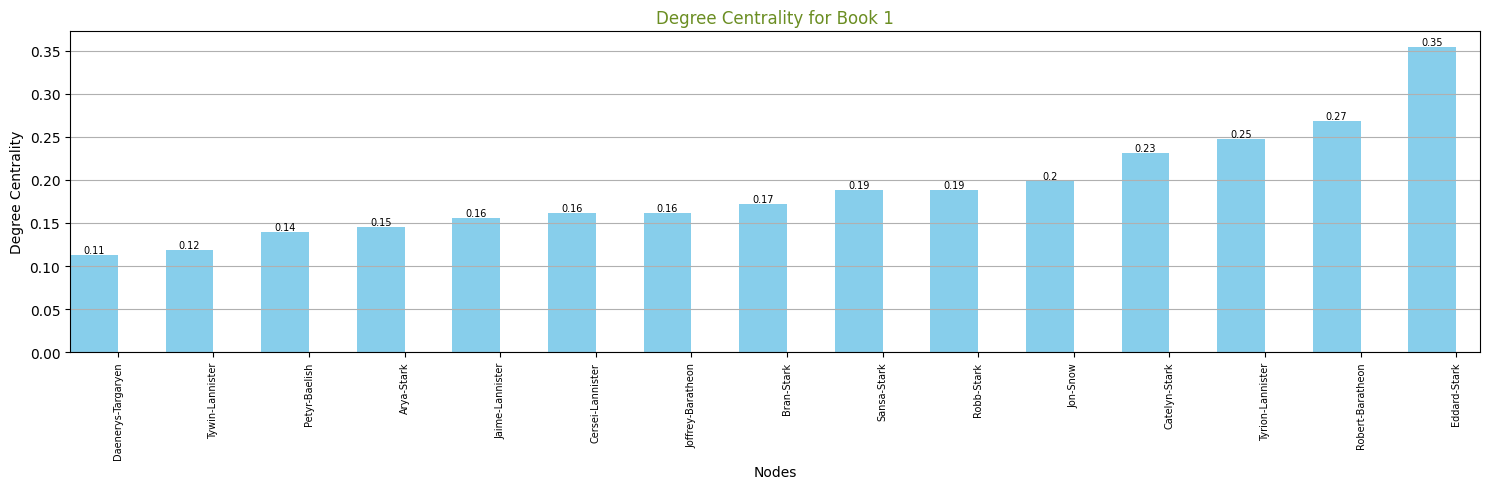

In [12]:
top_degree_nodes_1 = plot_degree_centrality(degree_1, 'Degree Centrality for Book 1', font_size=7, top_n=15)

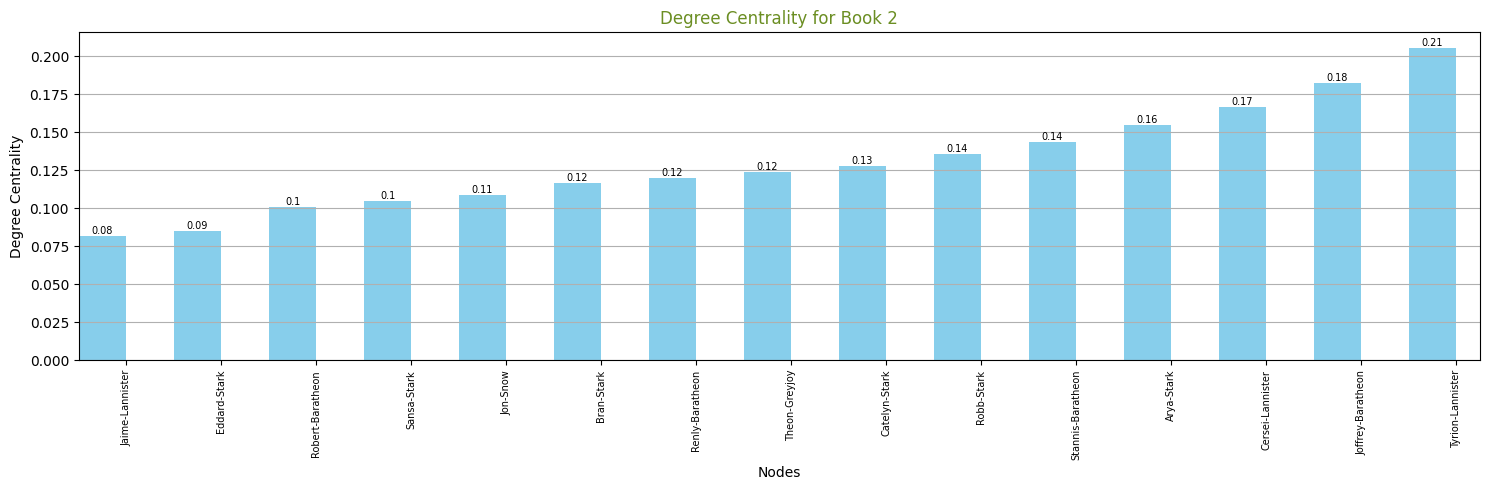

In [13]:
top_degree_nodes_2 = plot_degree_centrality(degree_2, 'Degree Centrality for Book 2', font_size=7, top_n=15)

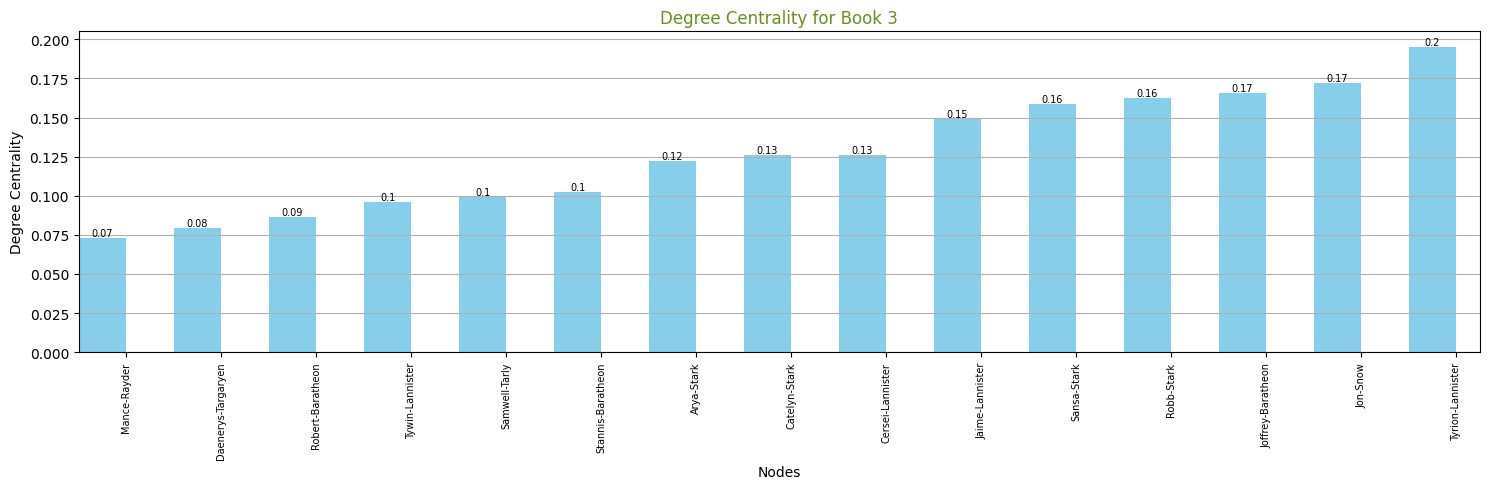

In [14]:
top_degree_nodes_3 = plot_degree_centrality(degree_3, 'Degree Centrality for Book 3', font_size=7, top_n=15)

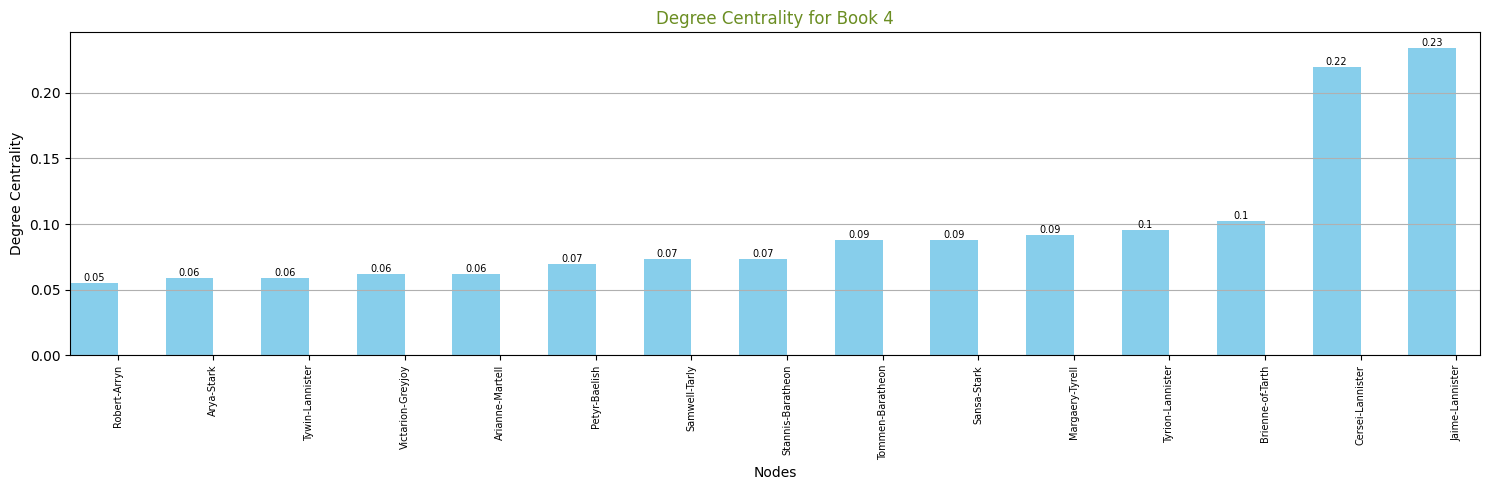

In [15]:
top_degree_nodes_4 = plot_degree_centrality(degree_4, 'Degree Centrality for Book 4', font_size=7, top_n=15)

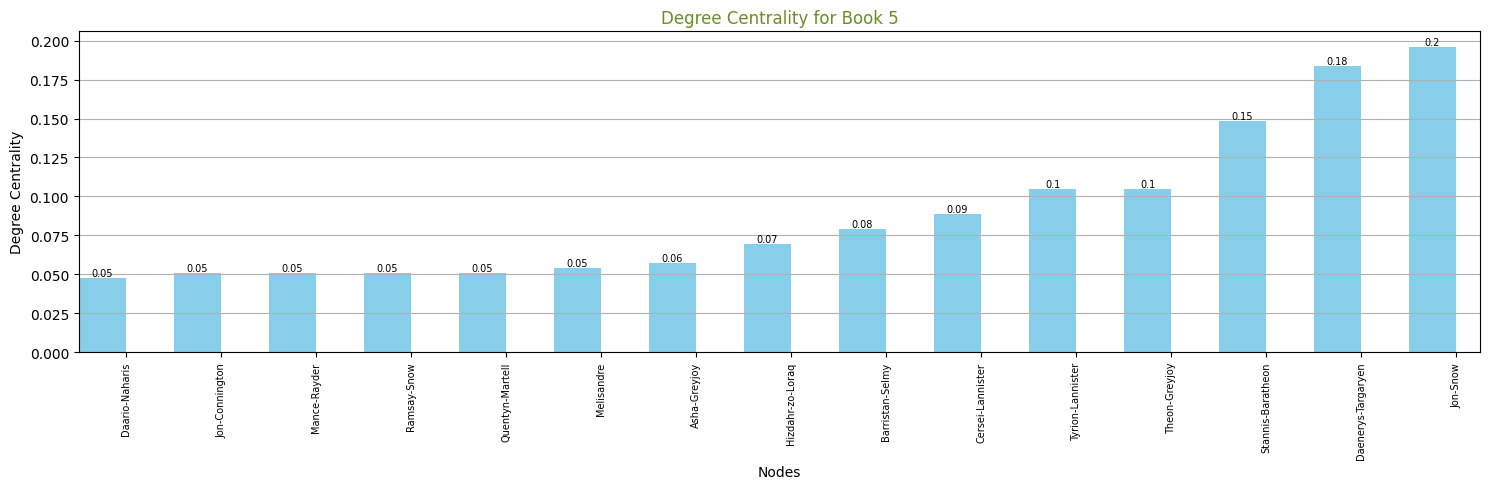

In [16]:
top_degree_nodes_5 = plot_degree_centrality(degree_5, 'Degree Centrality for Book 5', font_size=7, top_n=15)

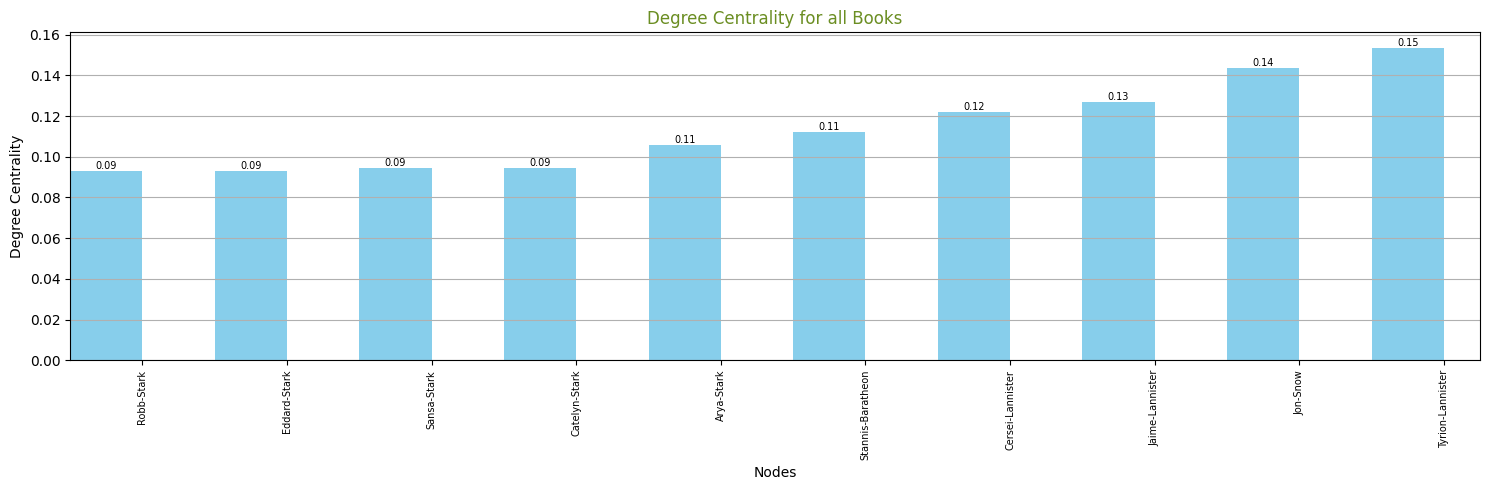

In [17]:
top_degree_nodes_all = plot_degree_centrality(degree_all, 'Degree Centrality for all Books', font_size=7, top_n=10)

In [18]:
top_common_nodes_DC = common_keys([top_degree_nodes_1, top_degree_nodes_2, top_degree_nodes_3, top_degree_nodes_4, top_degree_nodes_5])

In [19]:
top_common_nodes_DC

['Cersei-Lannister', 'Tyrion-Lannister']

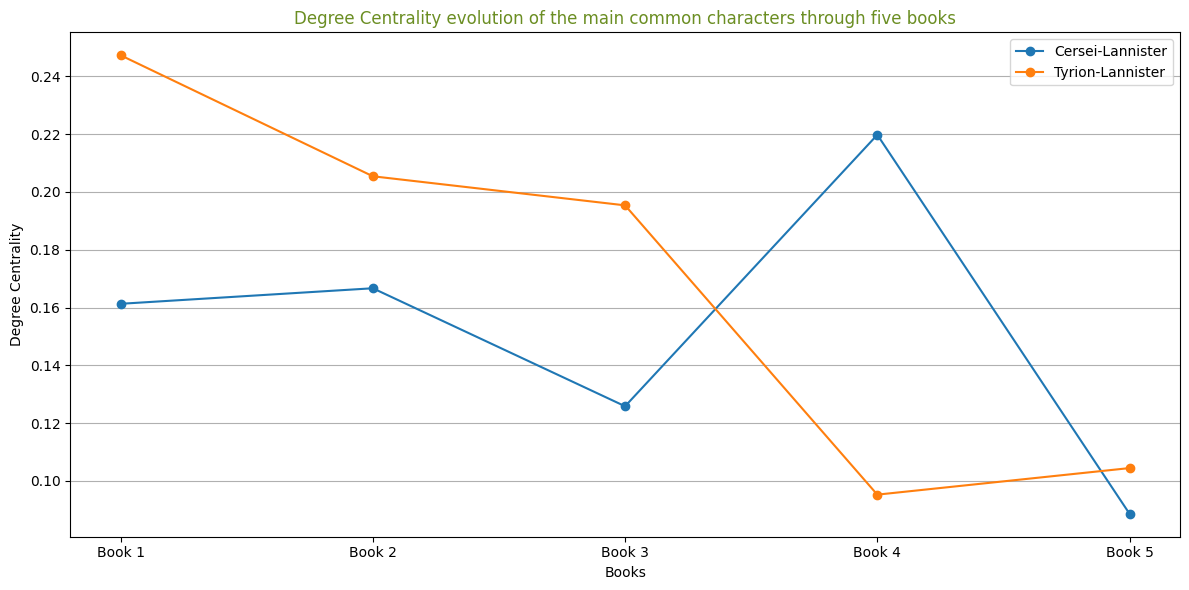

In [20]:
show_evolution([top_degree_nodes_1, top_degree_nodes_2, top_degree_nodes_3, top_degree_nodes_4, top_degree_nodes_5],
                        top_common_nodes_DC,
                        title="Degree Centrality evolution of the main common characters through five books",
                        xlabel="Books",
                        ylabel="Degree Centrality")

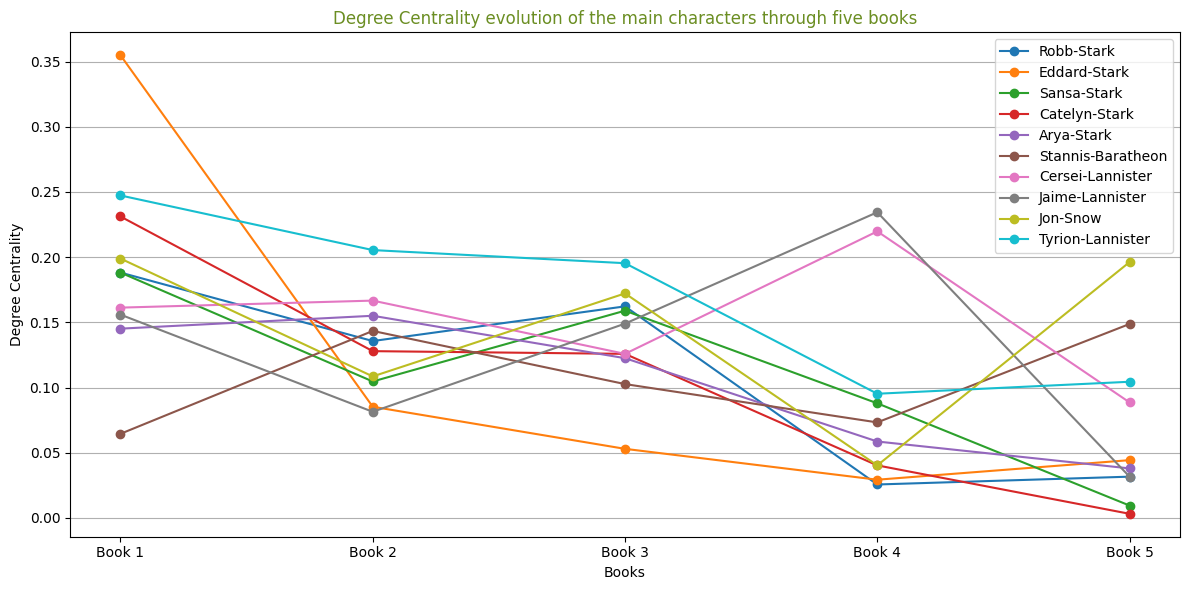

In [21]:
show_evolution([degree_1, degree_2, degree_3, degree_4, degree_5],
                        top_degree_nodes_all,
                        title="Degree Centrality evolution of the main characters through five books",
                        xlabel="Books",
                        ylabel="Degree Centrality")

### Eigenvector Centrality

In [22]:
def plot_eig_centrality(centrality, title, top_n=None, font_size=8, bar_width=1, spacing=1):
    """
    Plots the Eigenvector centrality of the given graph, showing only the top N elements if provided.

    Parameters:
    centrality (dict): The input graph centrality.
    title (str): The title for the plot.
    top_n (int or None): If None, all values are plotted. If an integer, only the top N values are plotted.
    font_size (int): The font size for the node labels in the plot.
    bar_width (float): The width of the bars in the histogram.
    spacing (float): The space between the bars.

    Returns:
    None: The function displays a plot of eigenvector centrality.
    """

    # Prepare data for plotting
    nodes = list(centrality.keys())
    values = list(centrality.values())

    # Sort values and get top N if specified
    if top_n is not None:
        sorted_indices = np.argsort(values)[-top_n:]  # Get indices of top N values
        filtered_nodes = [nodes[i] for i in sorted_indices]
        filtered_values = [values[i] for i in sorted_indices]
    else:
        filtered_nodes = nodes
        filtered_values = values

    # Create x-coordinates for bars with spacing
    x_positions = np.arange(len(filtered_nodes)) * (bar_width + spacing)

    # Create the plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(x_positions, filtered_values, color='skyblue', width=bar_width)  # Adjust bar positions here
    plt.xlabel('Nodes')
    plt.ylabel('Eigenvector Centrality')
    plt.title(title, color="olivedrab")
    plt.xticks(x_positions + bar_width / 2, filtered_nodes, rotation=90, fontsize=font_size)  # Center labels
    plt.grid(axis='y')
    plt.xlim(-0.5, len(filtered_nodes) * (bar_width + spacing) - spacing)  # Limiti dell'asse x

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=font_size)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return dict(zip(filtered_nodes, filtered_values))

In [23]:
eig_1 = nx.eigenvector_centrality(G_1, weight='Weight')
eig_2 = nx.eigenvector_centrality(G_2, weight='Weight')
eig_3 = nx.eigenvector_centrality(G_3, weight='Weight')
eig_4 = nx.eigenvector_centrality(G_4, weight='Weight')
eig_5 = nx.eigenvector_centrality(G_5, weight='Weight', max_iter=200)
eig_all = nx.eigenvector_centrality(G_all, weight='Weight')

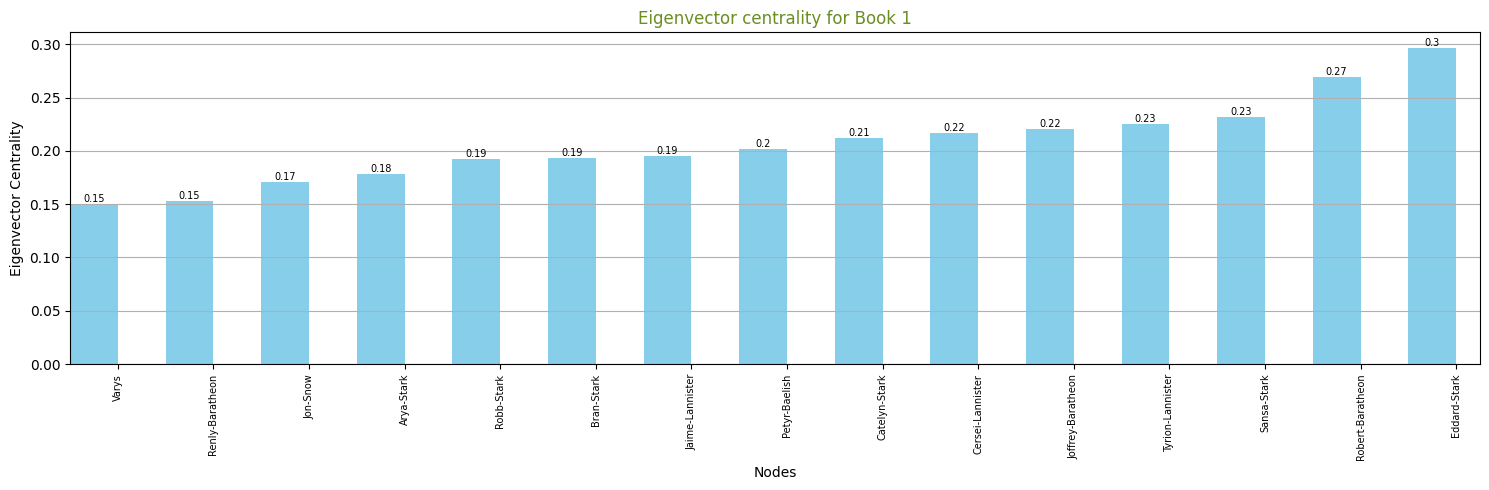

In [24]:
top_eig_nodes_1 = plot_eig_centrality(eig_1, 'Eigenvector centrality for Book 1', font_size=7, top_n=15)

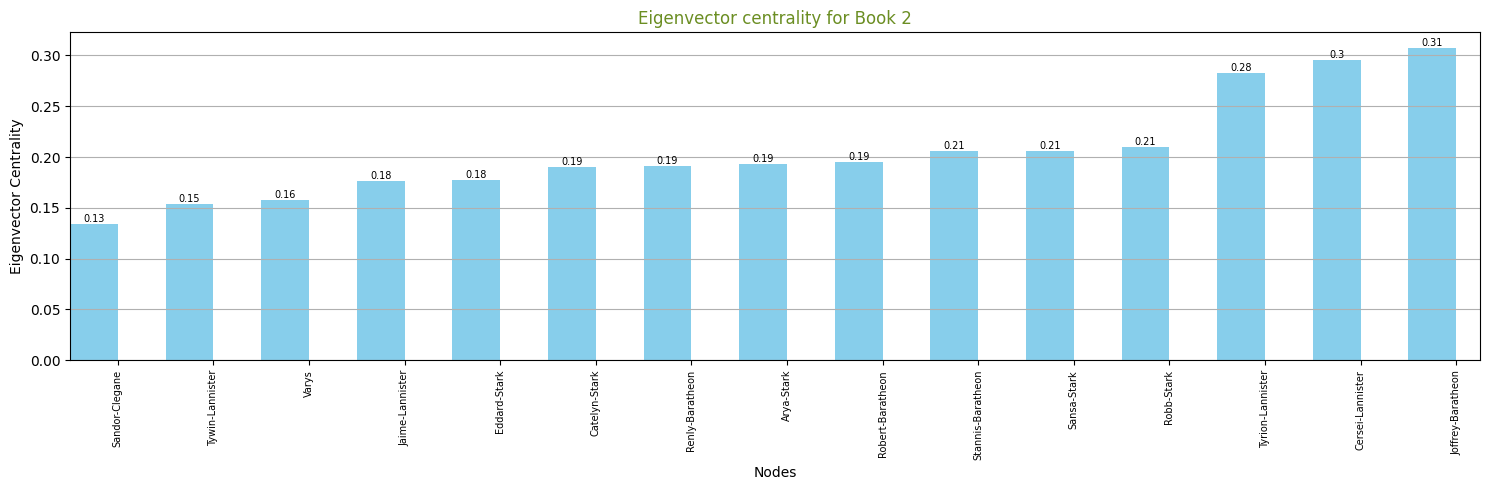

In [25]:
top_eig_nodes_2 = plot_eig_centrality(eig_2, 'Eigenvector centrality for Book 2', font_size=7, top_n=15)

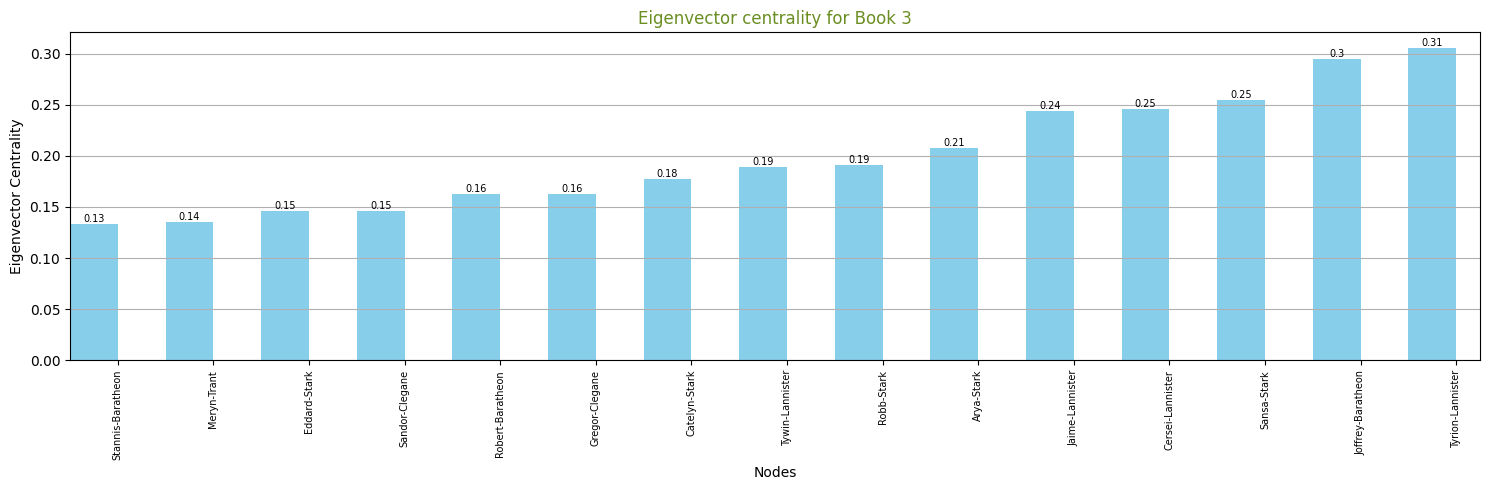

In [26]:
top_eig_nodes_3 = plot_eig_centrality(eig_3, 'Eigenvector centrality for Book 3', font_size=7, top_n=15)

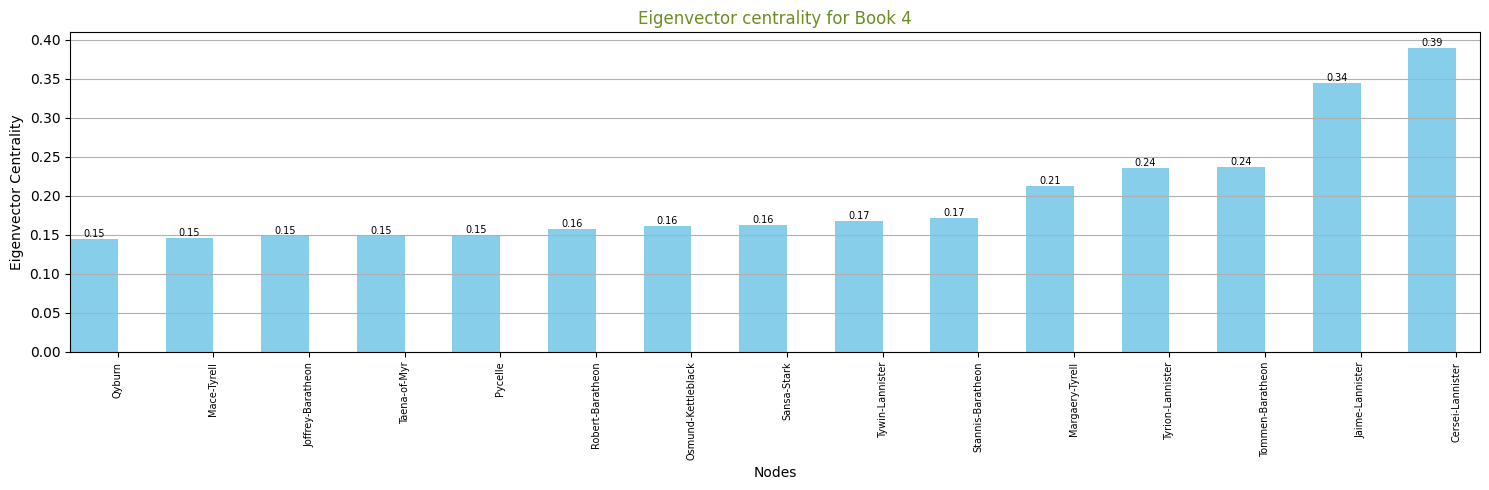

In [27]:
top_eig_nodes_4 = plot_eig_centrality(eig_4, 'Eigenvector centrality for Book 4', font_size=7, top_n=15)

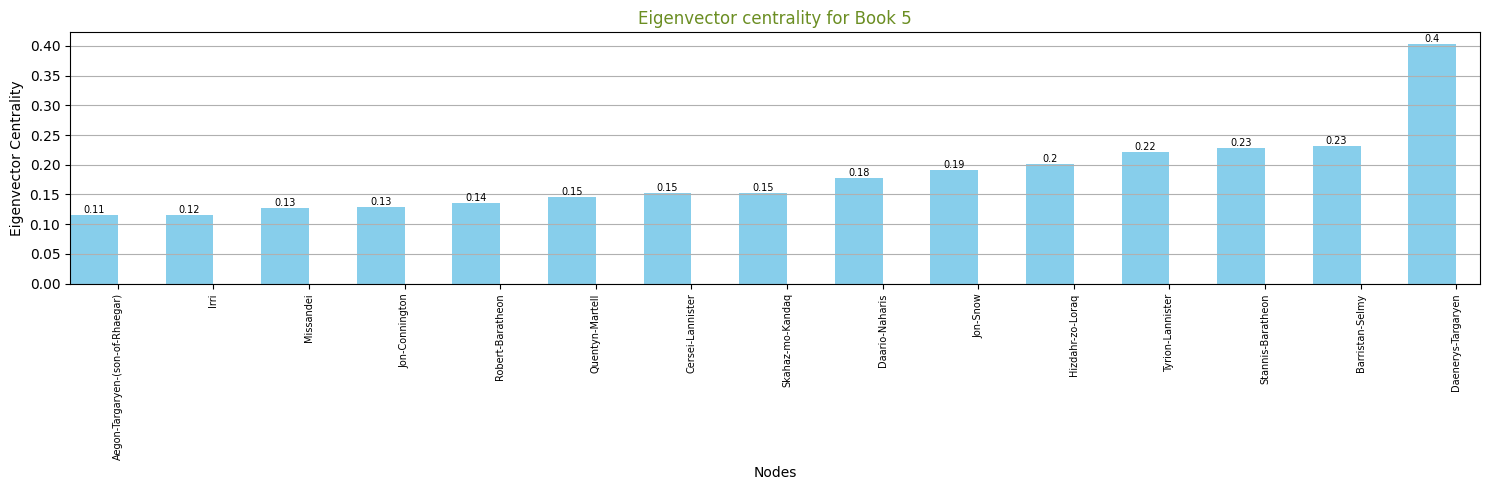

In [28]:
top_eig_nodes_5 = plot_eig_centrality(eig_5, 'Eigenvector centrality for Book 5', font_size=7, top_n=15)

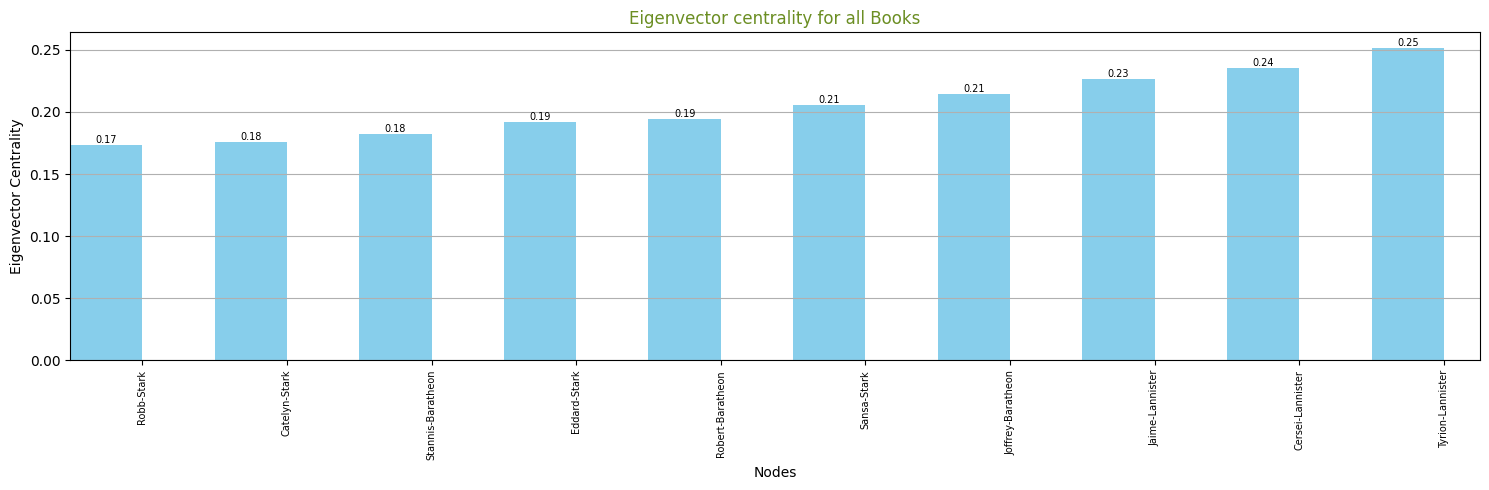

In [29]:
top_eig_nodes_all = plot_eig_centrality(eig_all, 'Eigenvector centrality for all Books', font_size=7, top_n=10)

In [30]:
top_common_nodes_EVC = common_keys([top_eig_nodes_1, top_eig_nodes_2, top_eig_nodes_3, top_eig_nodes_4, top_eig_nodes_5])

In [31]:
top_common_nodes_EVC

['Robert-Baratheon', 'Cersei-Lannister', 'Tyrion-Lannister']

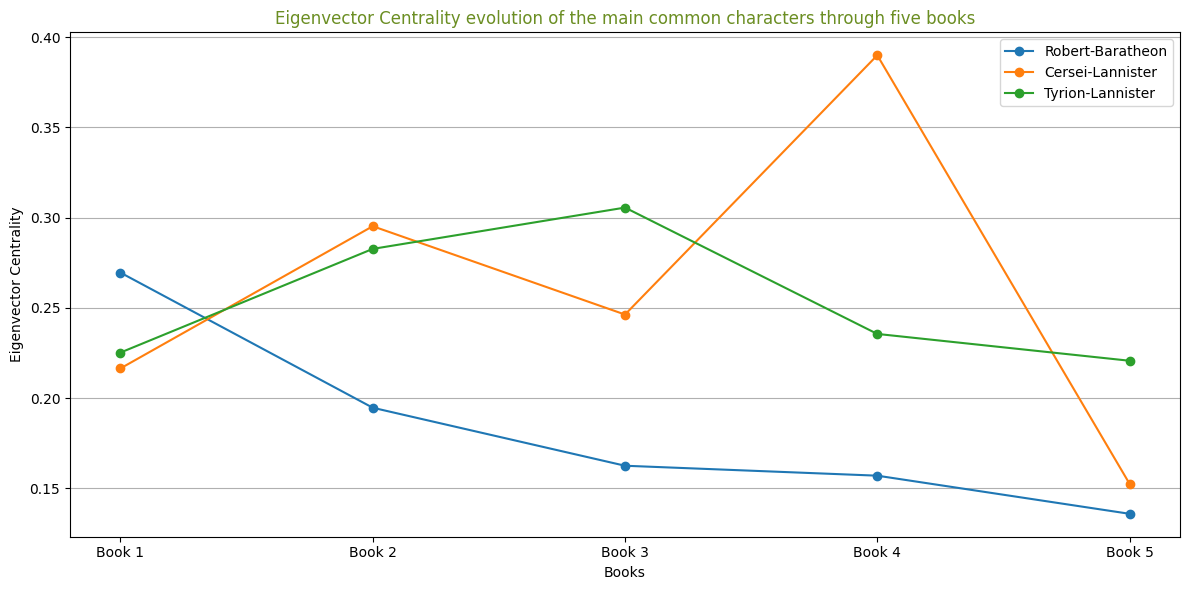

In [32]:
show_evolution([top_eig_nodes_1, top_eig_nodes_2, top_eig_nodes_3, top_eig_nodes_4, top_eig_nodes_5],
                        top_common_nodes_EVC,
                        title="Eigenvector Centrality evolution of the main common characters through five books",
                        xlabel="Books",
                        ylabel="Eigenvector Centrality")

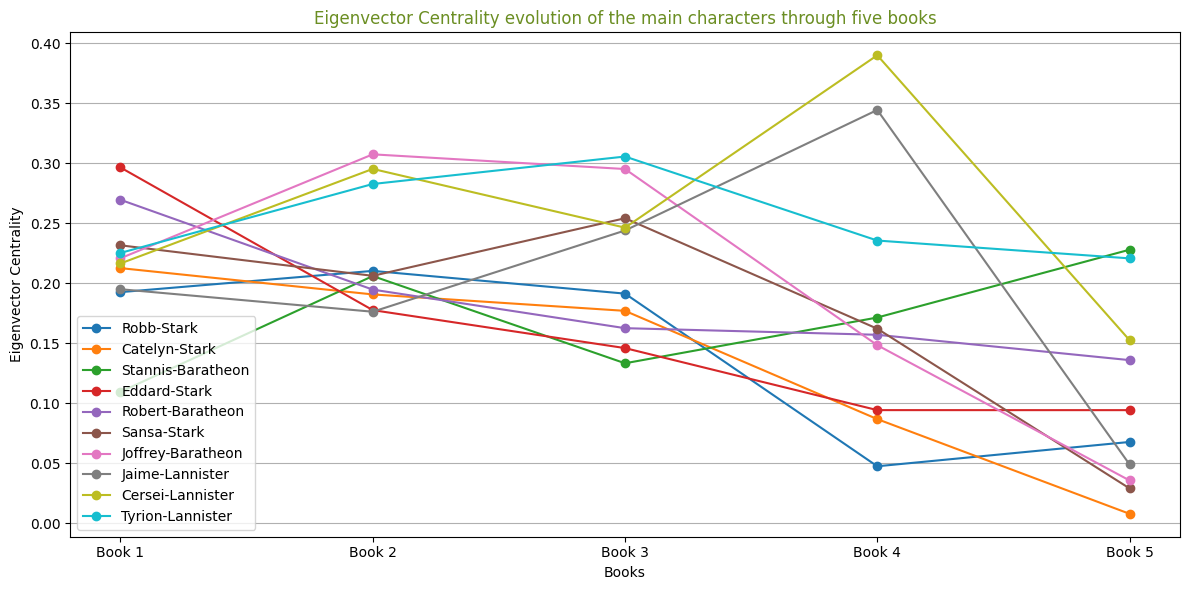

In [33]:
show_evolution([eig_1, eig_2, eig_3, eig_4, eig_5],
                        top_eig_nodes_all,
                        title="Eigenvector Centrality evolution of the main characters through five books",
                        xlabel="Books",
                        ylabel="Eigenvector Centrality")

### Katz Centrality

In [34]:
def plot_katz_centrality(centrality, title, top_n=None, font_size=8, bar_width=1, spacing=1):
    """
    Plots the Katz centrality of the given graph, showing only the top N elements if provided.

    Parameters:
    centrality (dict): The input graph centrality.
    title (str): The title for the plot.
    top_n (int or None): If None, all values are plotted. If an integer, only the top N values are plotted.
    font_size (int): The font size for the node labels in the plot.
    bar_width (float): The width of the bars in the histogram.
    spacing (float): The space between the bars.

    Returns:
    None: The function displays a plot of katz centrality.
    """

    # Prepare data for plotting
    nodes = list(centrality.keys())
    values = list(centrality.values())

    # Sort values and get top N if specified
    if top_n is not None:
        sorted_indices = np.argsort(values)[-top_n:]  # Get indices of top N values
        filtered_nodes = [nodes[i] for i in sorted_indices]
        filtered_values = [values[i] for i in sorted_indices]
    else:
        filtered_nodes = nodes
        filtered_values = values

    # Create x-coordinates for bars with spacing
    x_positions = np.arange(len(filtered_nodes)) * (bar_width + spacing)

    # Create the plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(x_positions, filtered_values, color='skyblue', width=bar_width)  # Adjust bar positions here
    plt.xlabel('Nodes')
    plt.ylabel('Katz Centrality')
    plt.title(title, color="olivedrab")
    plt.xticks(x_positions + bar_width / 2, filtered_nodes, rotation=90, fontsize=font_size)  # Center labels
    plt.grid(axis='y')
    plt.xlim(-0.5, len(filtered_nodes) * (bar_width + spacing) - spacing)  # Limiti dell'asse x

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=font_size)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return dict(zip(filtered_nodes, filtered_values))

In [35]:
max_eig = max(nx.adjacency_spectrum(G_1, weight='weight')).real
katz_1 = nx.katz_centrality_numpy(G_1, alpha = 1/(max_eig+1), weight='Weight')

max_eig = max(nx.adjacency_spectrum(G_2, weight='weight')).real
katz_2 = nx.katz_centrality_numpy(G_2, alpha = 1/(max_eig+1), weight='Weight')

max_eig = max(nx.adjacency_spectrum(G_3, weight='weight')).real
katz_3 = nx.katz_centrality_numpy(G_3, alpha = 1/(max_eig+1), weight='Weight')

max_eig = max(nx.adjacency_spectrum(G_4, weight='weight')).real
katz_4 = nx.katz_centrality_numpy(G_4, alpha = 1/(max_eig+1), weight='Weight')

max_eig = max(nx.adjacency_spectrum(G_5, weight='weight')).real
katz_5 = nx.katz_centrality_numpy(G_5, alpha = 1/(max_eig+1), weight='Weight')

max_eig = max(nx.adjacency_spectrum(G_all, weight='weight')).real
katz_all = nx.katz_centrality_numpy(G_all, alpha = 1/(max_eig+1), weight='Weight')

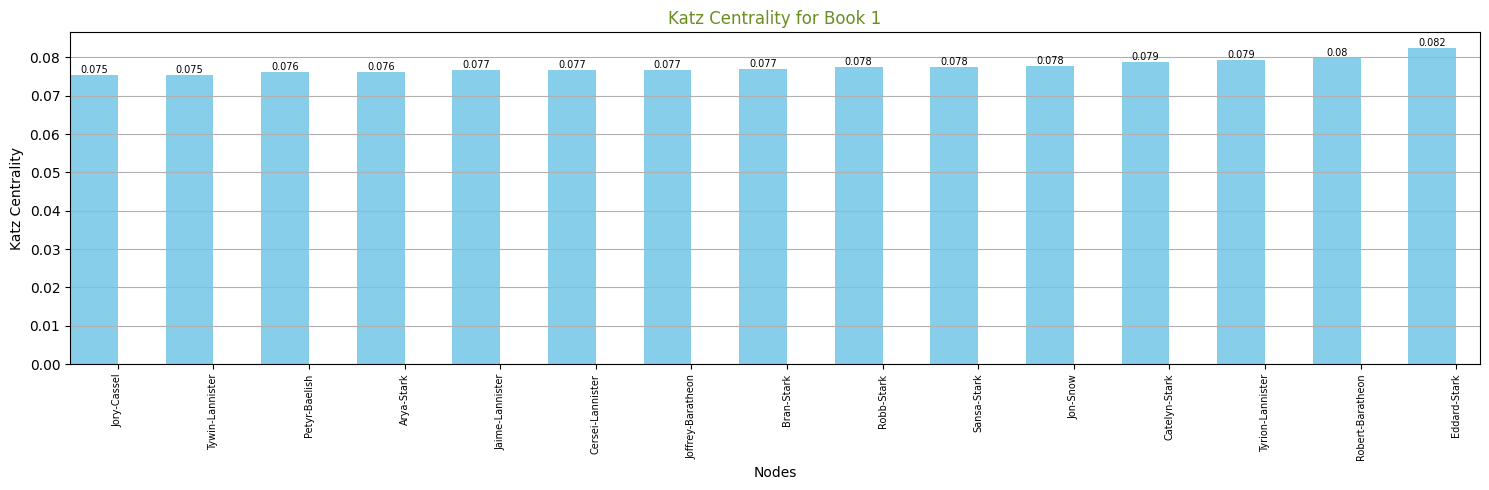

In [36]:
top_katz_nodes_1 = plot_katz_centrality(katz_1, 'Katz Centrality for Book 1', font_size=7, top_n=15)

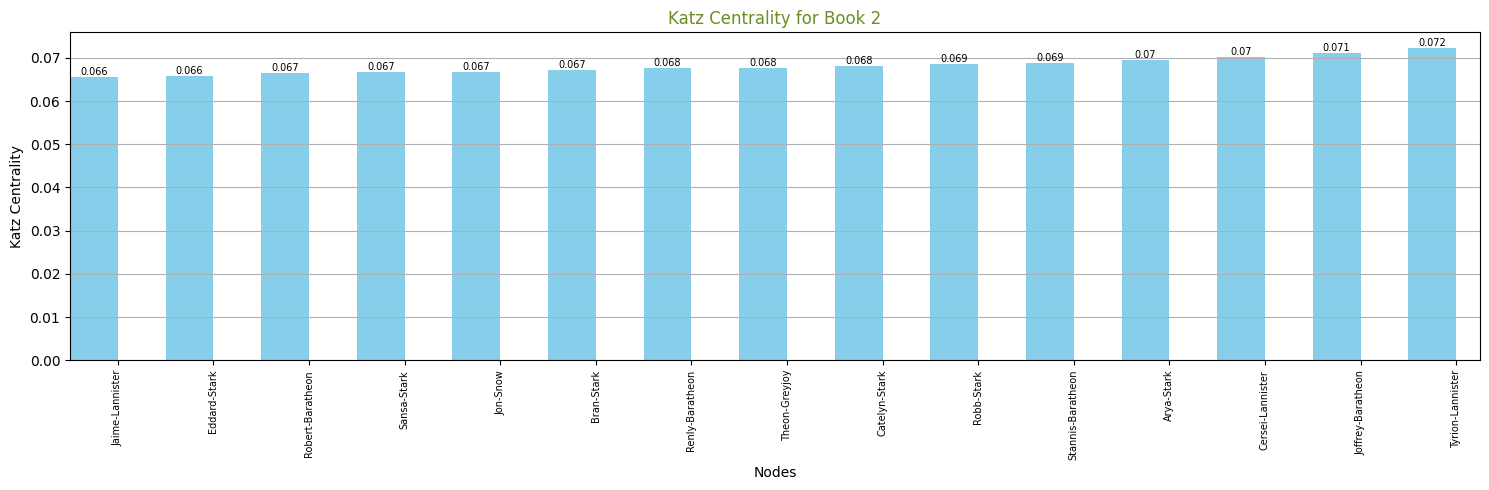

In [37]:
top_katz_nodes_2 = plot_katz_centrality(katz_2, 'Katz Centrality for Book 2', font_size=7, top_n=15)

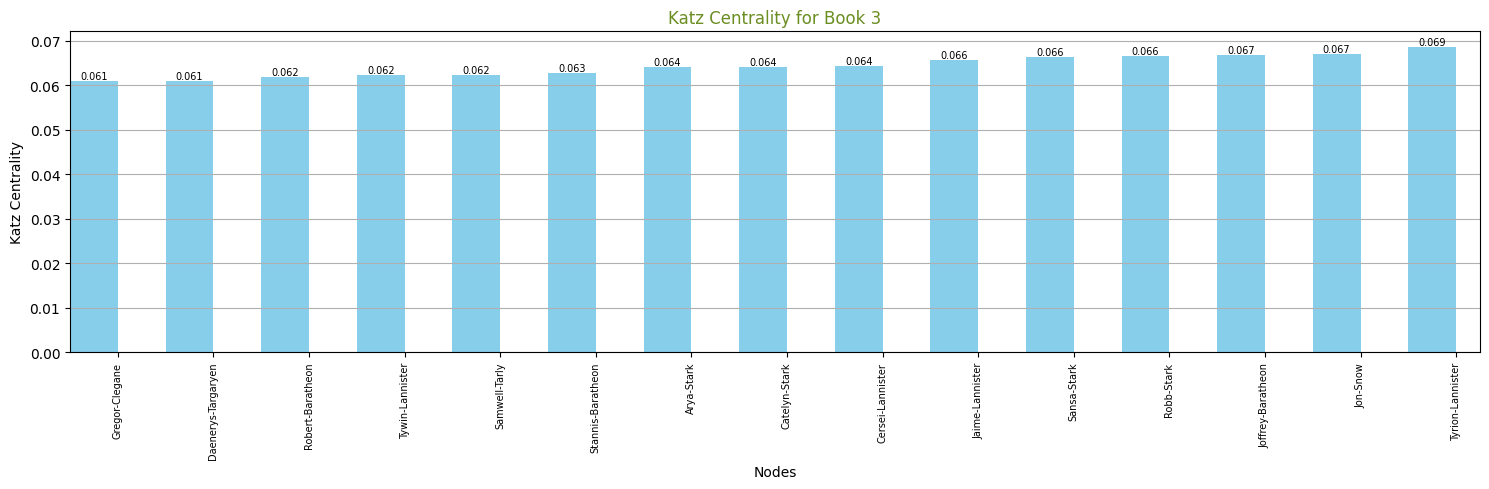

In [38]:
top_katz_nodes_3 = plot_katz_centrality(katz_3, 'Katz Centrality for Book 3', font_size=7, top_n=15)

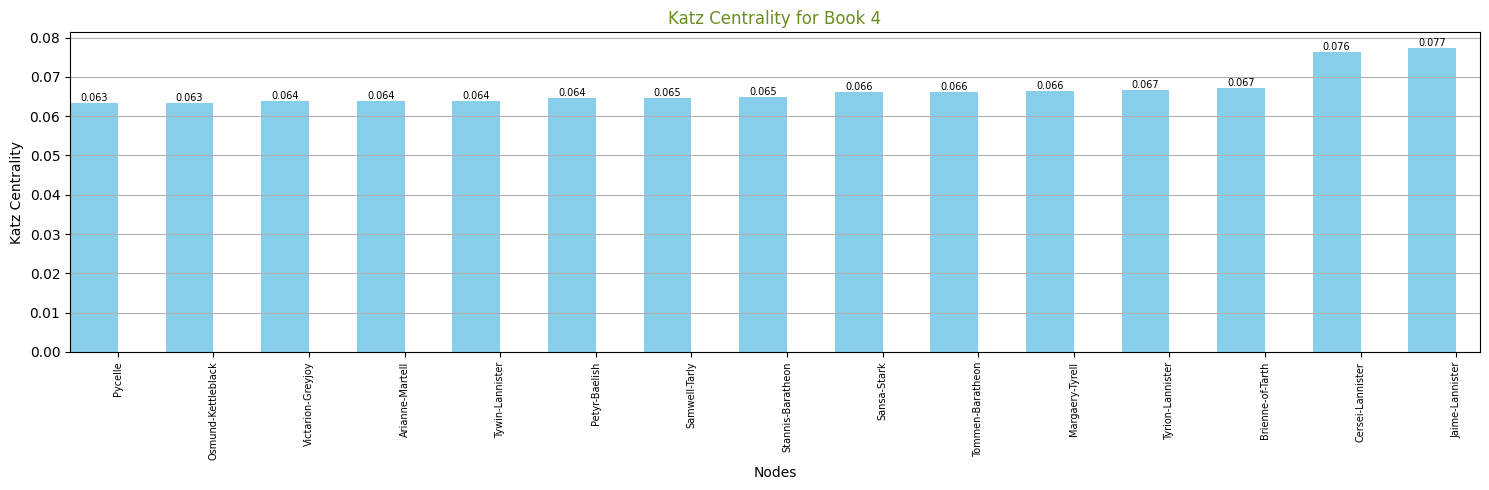

In [39]:
top_katz_nodes_4 = plot_katz_centrality(katz_4, 'Katz Centrality for Book 4', font_size=7, top_n=15)

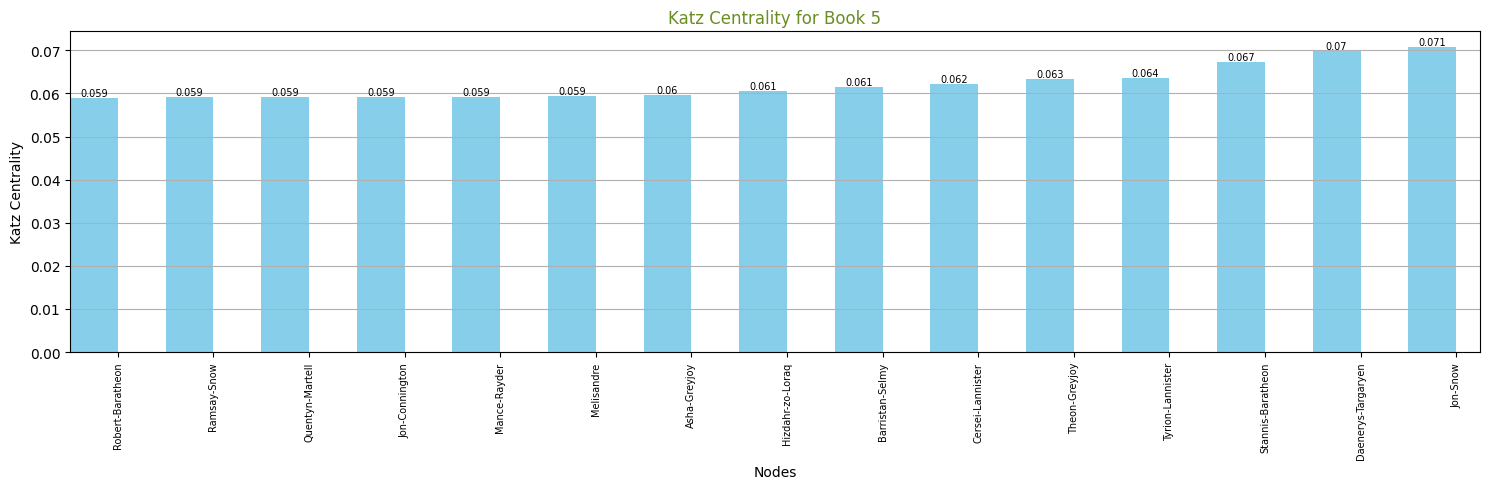

In [40]:
top_katz_nodes_5 = plot_katz_centrality(katz_5, 'Katz Centrality for Book 5', font_size=7, top_n=15)

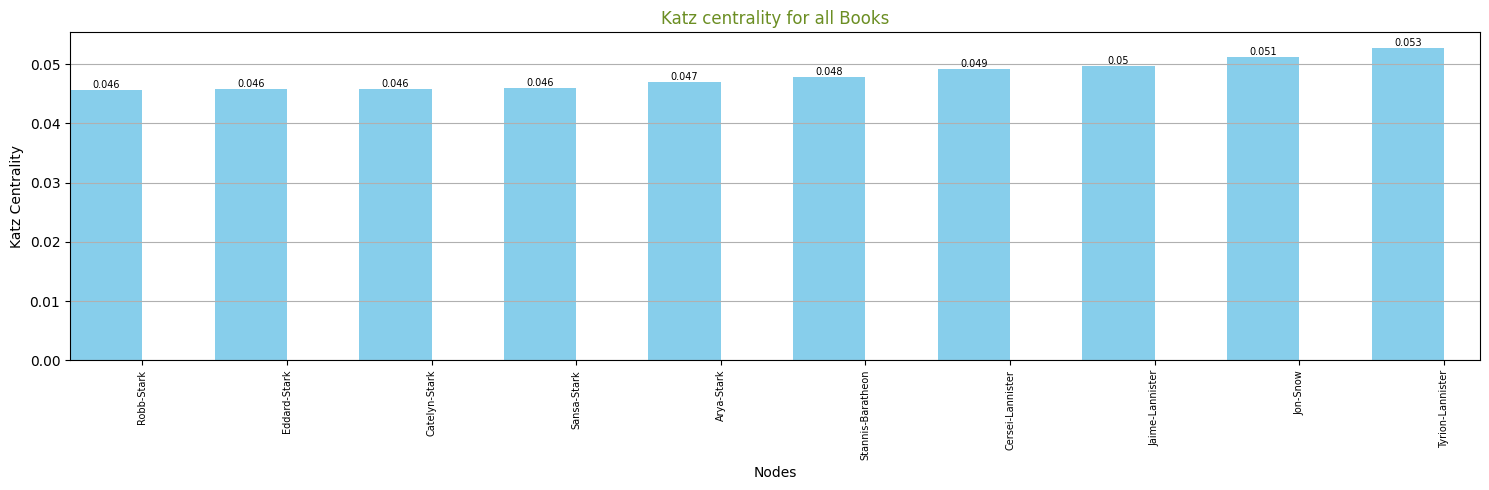

In [41]:
top_katz_nodes_all = plot_katz_centrality(katz_all, 'Katz centrality for all Books', font_size=7, top_n=10)

In [42]:
top_common_nodes_KC = common_keys([top_katz_nodes_1, top_katz_nodes_2, top_katz_nodes_3, top_katz_nodes_4, top_katz_nodes_5])

In [43]:
top_common_nodes_KC

['Cersei-Lannister', 'Tyrion-Lannister']

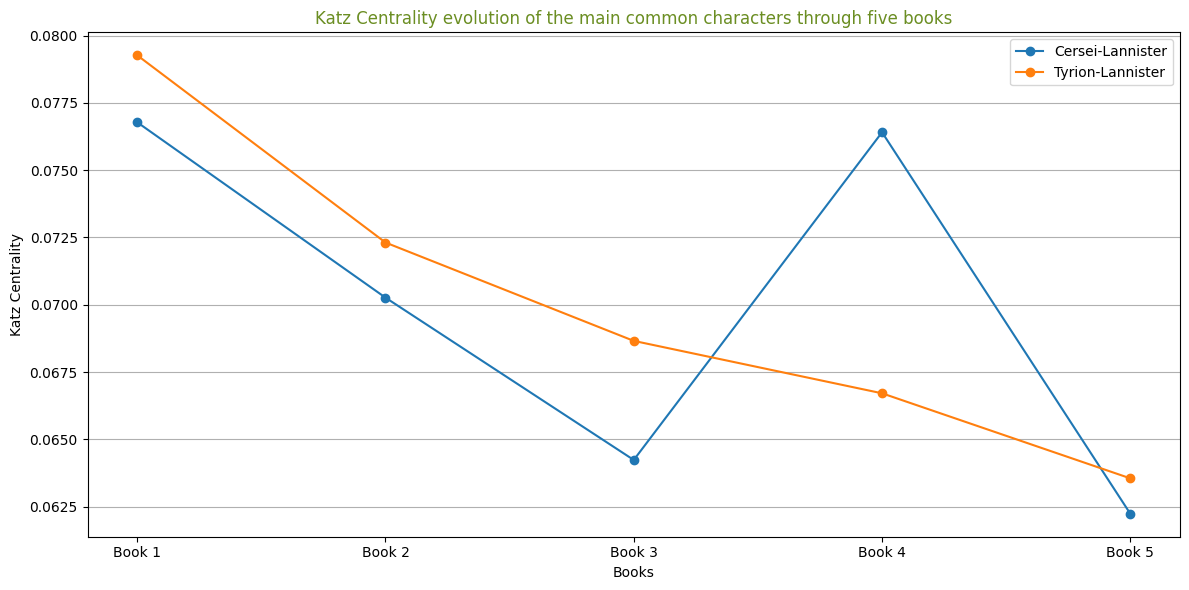

In [44]:
show_evolution([top_katz_nodes_1, top_katz_nodes_2, top_katz_nodes_3, top_katz_nodes_4, top_katz_nodes_5],
                        top_common_nodes_KC,
                        title="Katz Centrality evolution of the main common characters through five books",
                        xlabel="Books",
                        ylabel="Katz Centrality")

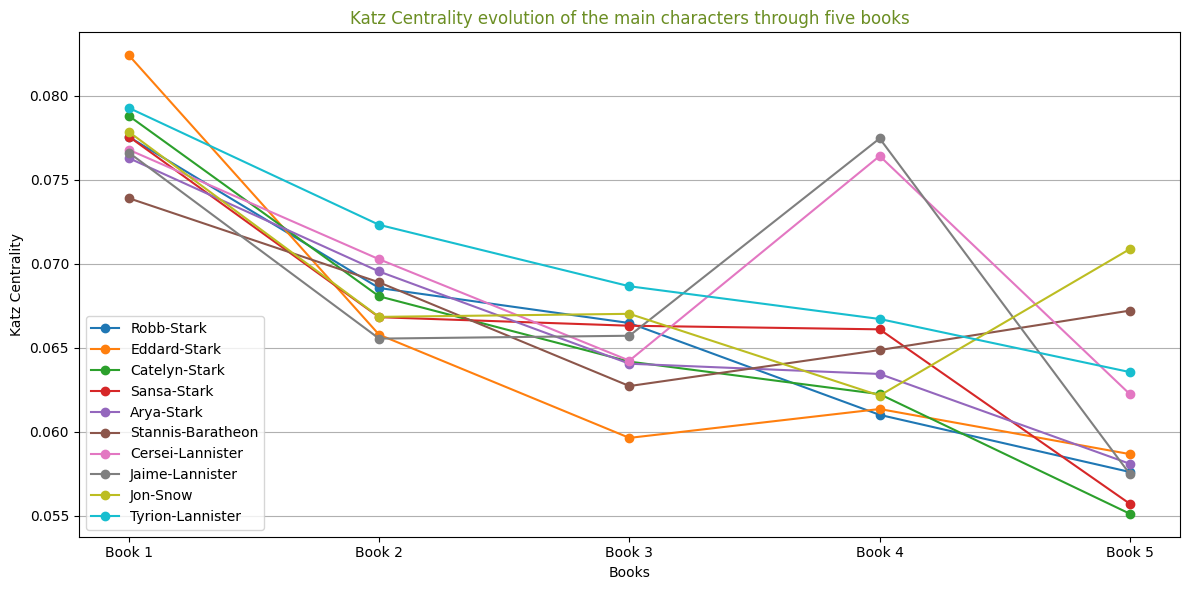

In [45]:
show_evolution([katz_1, katz_2, katz_3, katz_4, katz_5],
                        top_katz_nodes_all,
                        title="Katz Centrality evolution of the main characters through five books",
                        xlabel="Books",
                        ylabel="Katz Centrality")

### Closeness Centrality

In [46]:
def plot_closeness_centrality(centrality, title, top_n=None, font_size=8, bar_width=1, spacing=1):
    """
    Plots the Closeness centrality of the given graph, showing only the top N elements if provided.

    Parameters:
    centrality (dict): The input graph centrality.
    title (str): The title for the plot.
    top_n (int or None): If None, all values are plotted. If an integer, only the top N values are plotted.
    font_size (int): The font size for the node labels in the plot.
    bar_width (float): The width of the bars in the histogram.
    spacing (float): The space between the bars.

    Returns:
    None: The function displays a plot of closeness centrality.
    """

    # Prepare data for plotting
    nodes = list(centrality.keys())
    values = list(centrality.values())

    # Sort values and get top N if specified
    if top_n is not None:
        sorted_indices = np.argsort(values)[-top_n:]  # Get indices of top N values
        filtered_nodes = [nodes[i] for i in sorted_indices]
        filtered_values = [values[i] for i in sorted_indices]
    else:
        filtered_nodes = nodes
        filtered_values = values

    # Create x-coordinates for bars with spacing
    x_positions = np.arange(len(filtered_nodes)) * (bar_width + spacing)

    # Create the plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(x_positions, filtered_values, color='skyblue', width=bar_width)  # Adjust bar positions here
    plt.xlabel('Nodes')
    plt.ylabel('Closensess Centrality')
    plt.title(title, color="olivedrab")
    plt.xticks(x_positions + bar_width / 2, filtered_nodes, rotation=90, fontsize=font_size)  # Center labels
    plt.grid(axis='y')
    plt.xlim(-0.5, len(filtered_nodes) * (bar_width + spacing) - spacing)  # Limiti dell'asse x

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=font_size)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return dict(zip(filtered_nodes, filtered_values))

In [47]:
close_1 = nx.closeness_centrality(G_1, u=None, distance=1)
close_2 = nx.closeness_centrality(G_2, u=None, distance=1)
close_3 = nx.closeness_centrality(G_3, u=None, distance=1)
close_4 = nx.closeness_centrality(G_4, u=None, distance=1)
close_5 = nx.closeness_centrality(G_5, u=None, distance=1)
close_all = nx.closeness_centrality(G_all, u=None, distance=1)

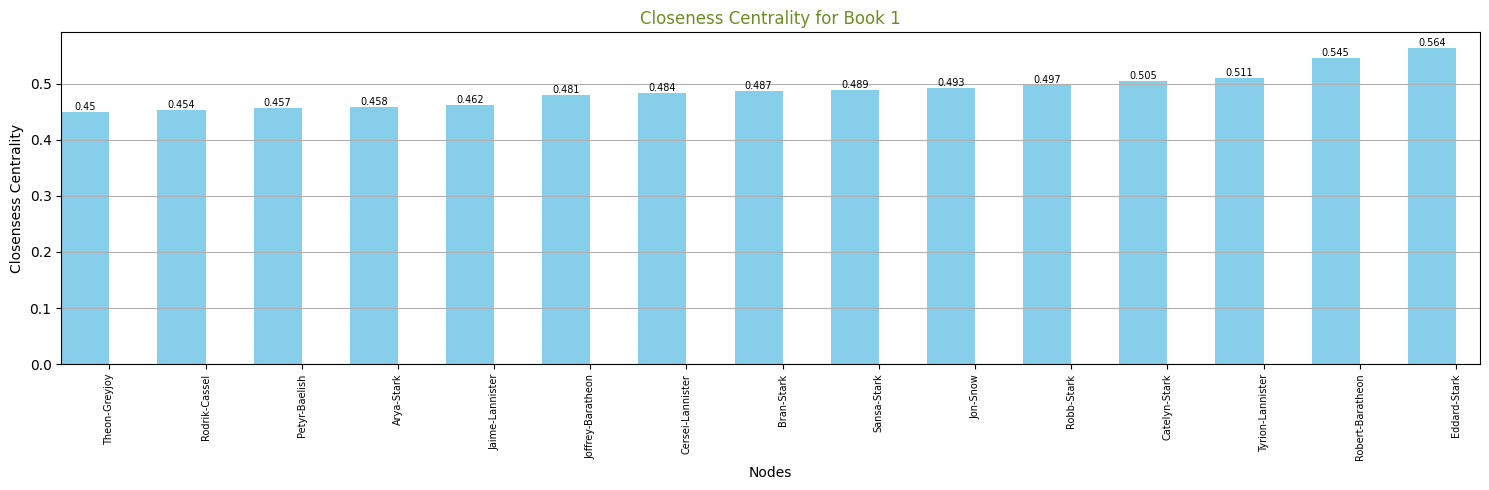

In [48]:
top_close_nodes_1 = plot_closeness_centrality(close_1, 'Closeness Centrality for Book 1', font_size=7, top_n=15)

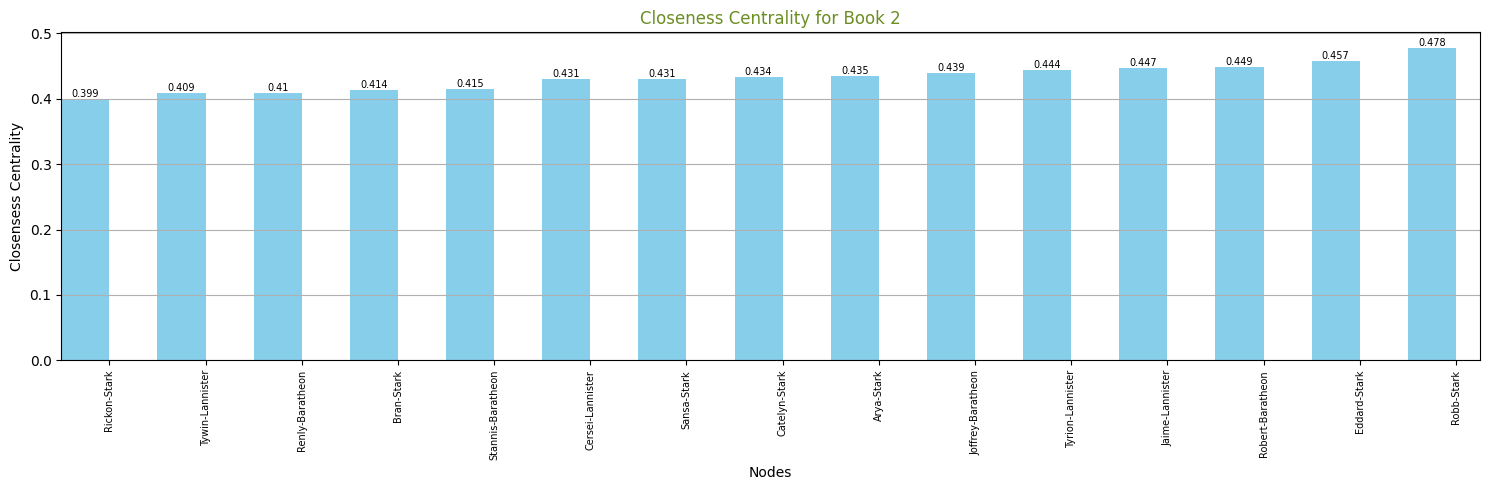

In [49]:
top_close_nodes_2 = plot_closeness_centrality(close_2, 'Closeness Centrality for Book 2', font_size=7, top_n=15)

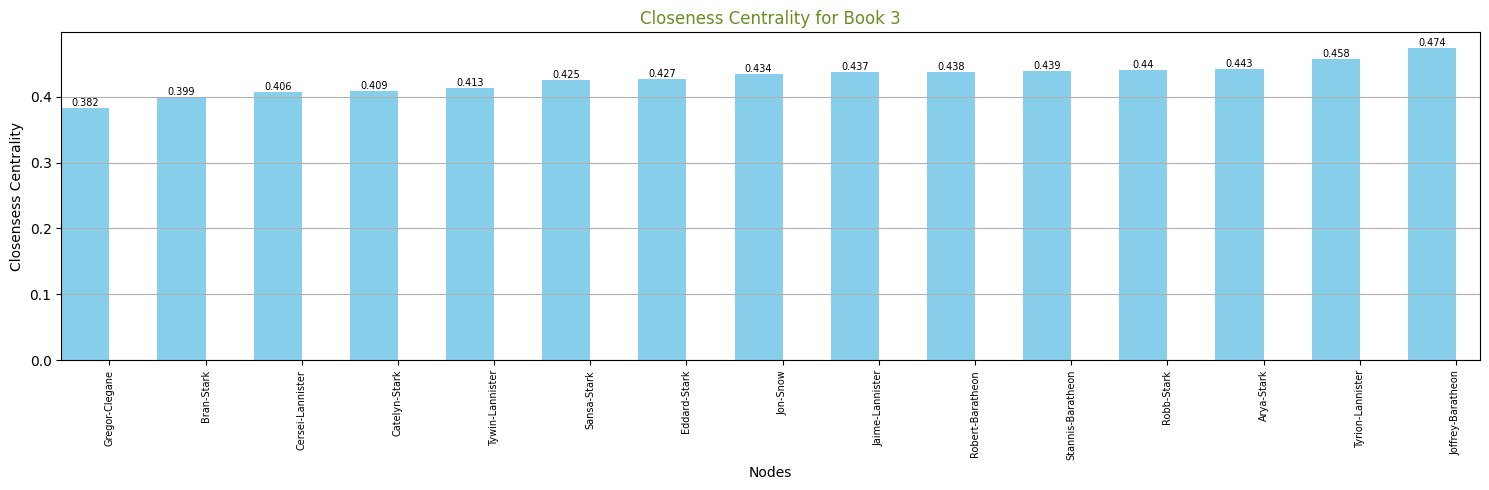

In [50]:
top_close_nodes_3 = plot_closeness_centrality(close_3, 'Closeness Centrality for Book 3', font_size=7, top_n=15)

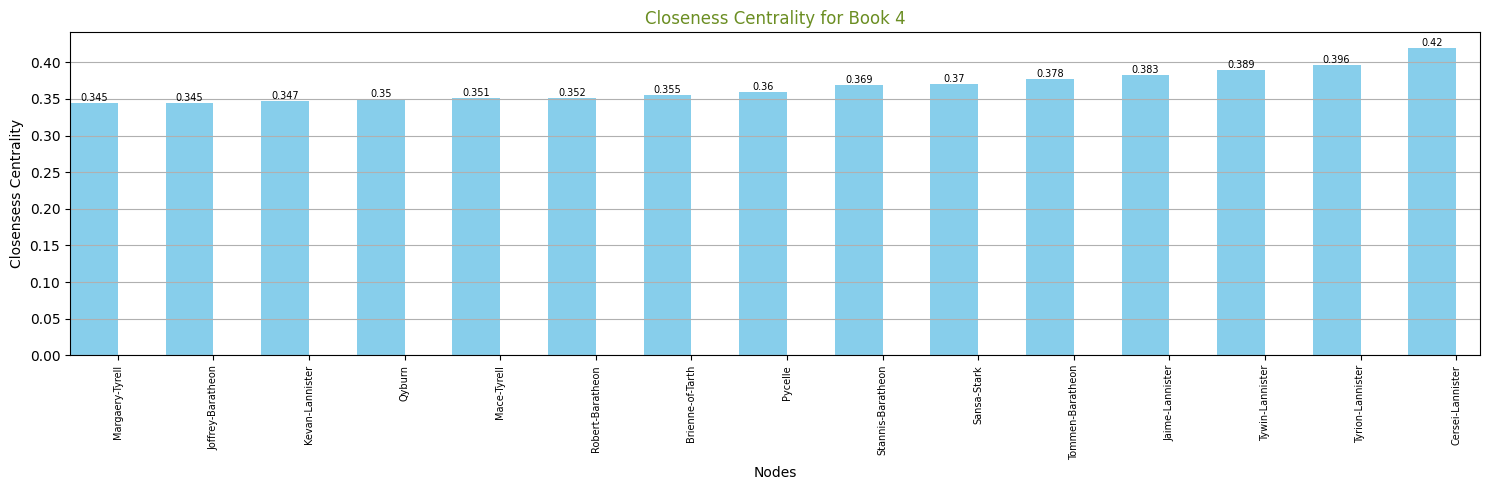

In [51]:
top_close_nodes_4 = plot_closeness_centrality(close_4, 'Closeness Centrality for Book 4', font_size=7, top_n=15)

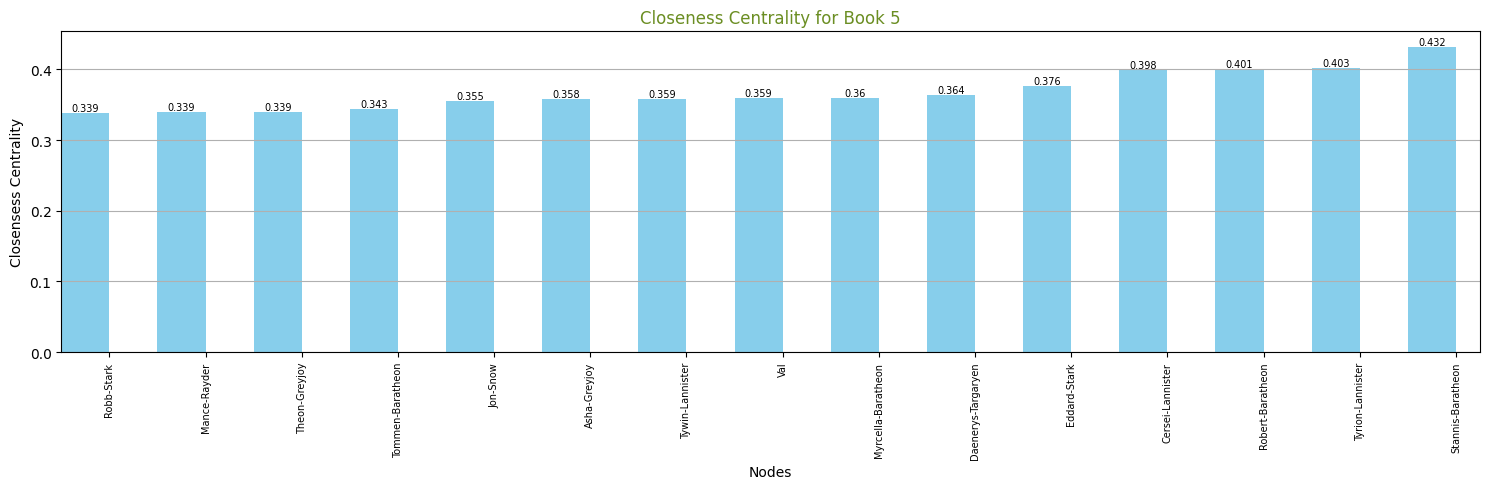

In [52]:
top_close_nodes_5 = plot_closeness_centrality(close_5, 'Closeness Centrality for Book 5', font_size=7, top_n=15)

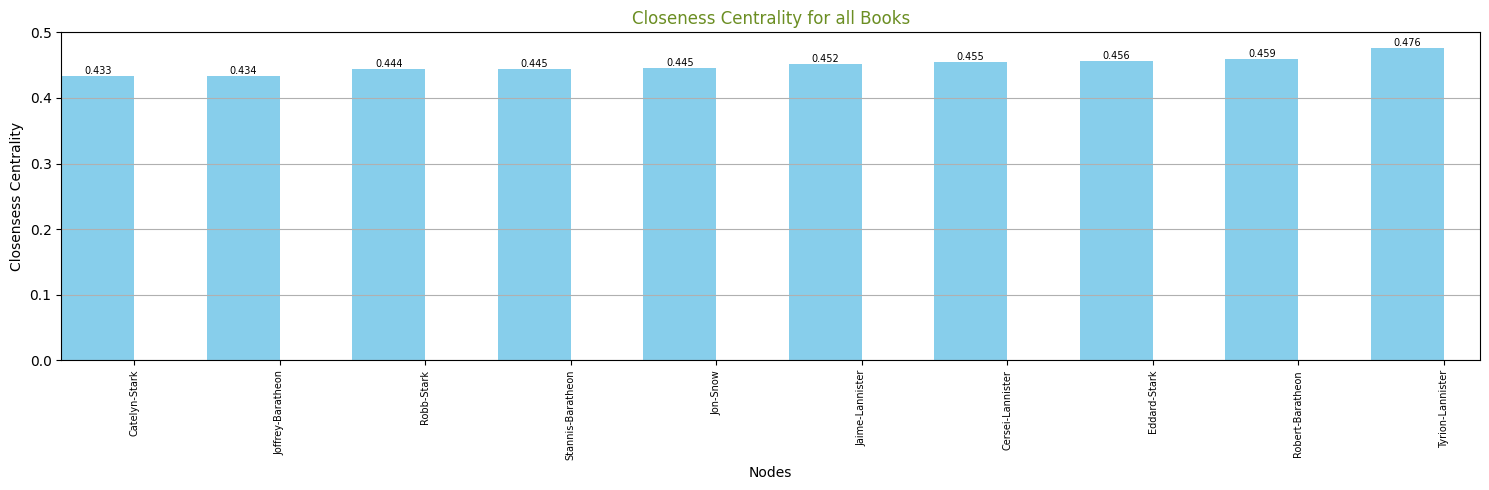

In [53]:
top_close_nodes_all = plot_closeness_centrality(close_all, 'Closeness Centrality for all Books', font_size=7, top_n=10)

In [54]:
top_common_nodes_CC = common_keys([top_close_nodes_1, top_close_nodes_2, top_close_nodes_3, top_close_nodes_4, top_close_nodes_5])

In [55]:
top_common_nodes_CC

['Robert-Baratheon', 'Cersei-Lannister', 'Tyrion-Lannister']

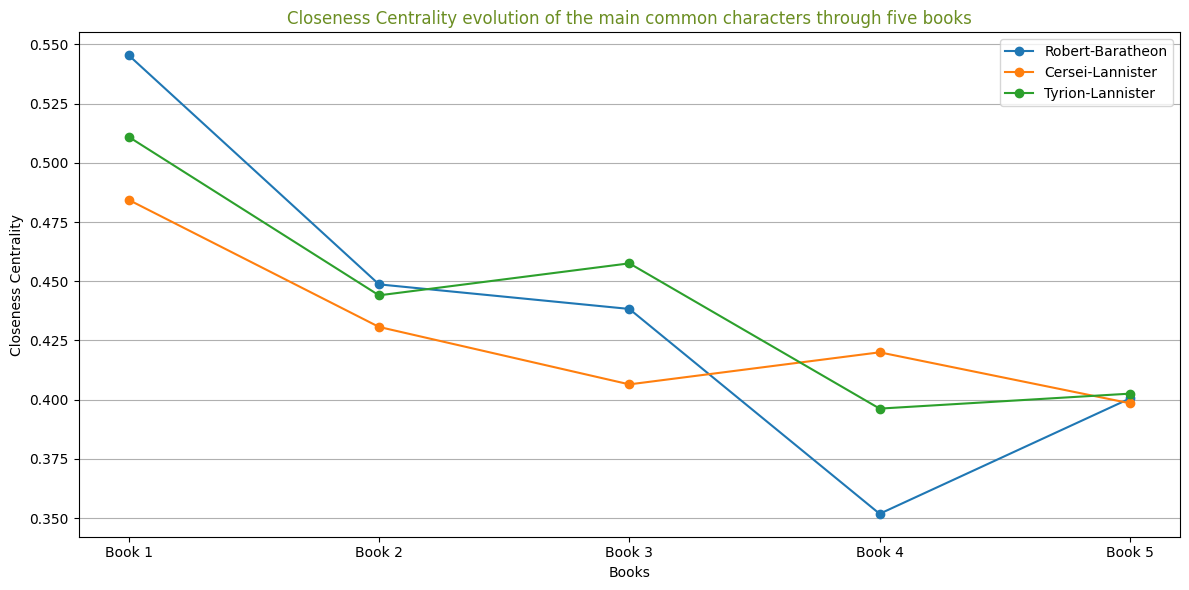

In [56]:
show_evolution([top_close_nodes_1, top_close_nodes_2, top_close_nodes_3, top_close_nodes_4, top_close_nodes_5],
                        top_common_nodes_CC,
                        title="Closeness Centrality evolution of the main common characters through five books",
                        xlabel="Books",
                        ylabel="Closeness Centrality")

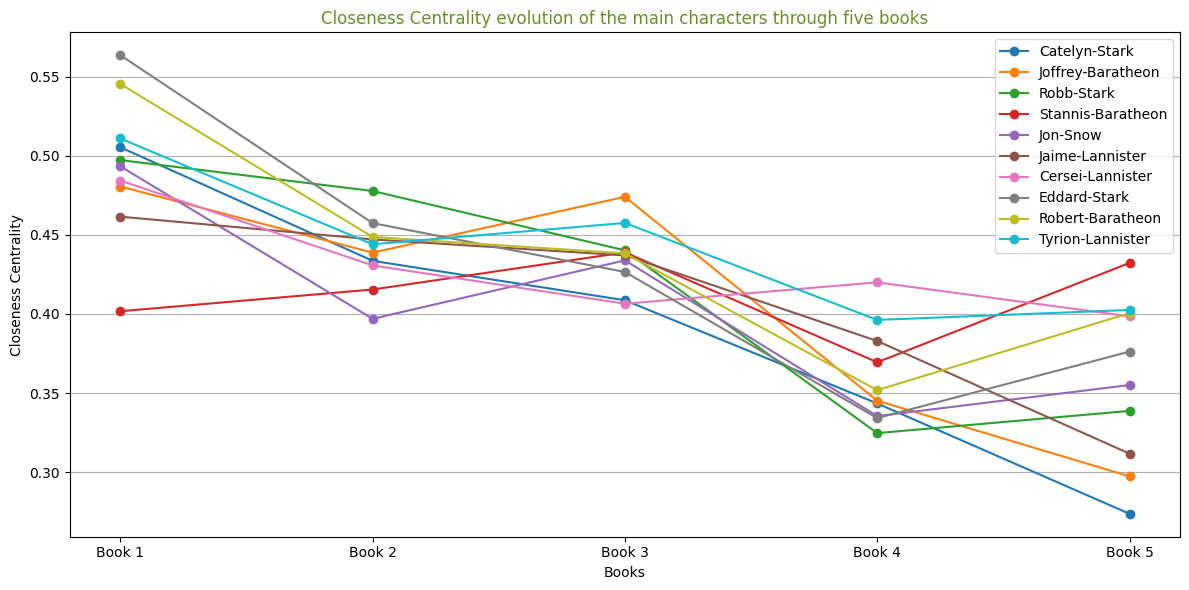

In [57]:
show_evolution([close_1, close_2, close_3, close_4, close_5],
                        top_close_nodes_all,
                        title="Closeness Centrality evolution of the main characters through five books",
                        xlabel="Books",
                        ylabel="Closeness Centrality")

### Betweenness Centrality

In [58]:
def plot_betweenness_centrality(centrality, title, top_n=None, font_size=8, bar_width=1, spacing=1):
    """
    Plots the Betweenness centrality of the given graph, showing only the top N elements if provided.

    Parameters:
    centrality (dict): The input graph centrality.
    title (str): The title for the plot.
    top_n (int or None): If None, all values are plotted. If an integer, only the top N values are plotted.
    font_size (int): The font size for the node labels in the plot.
    bar_width (float): The width of the bars in the histogram.
    spacing (float): The space between the bars.

    Returns:
    None: The function displays a plot of Betweenness centrality.
    """

    # Prepare data for plotting
    nodes = list(centrality.keys())
    values = list(centrality.values())

    # Sort values and get top N if specified
    if top_n is not None:
        sorted_indices = np.argsort(values)[-top_n:]  # Get indices of top N values
        filtered_nodes = [nodes[i] for i in sorted_indices]
        filtered_values = [values[i] for i in sorted_indices]
    else:
        filtered_nodes = nodes
        filtered_values = values

    # Create x-coordinates for bars with spacing
    x_positions = np.arange(len(filtered_nodes)) * (bar_width + spacing)

    # Create the plot
    plt.figure(figsize=(15, 5))
    bars = plt.bar(x_positions, filtered_values, color='skyblue', width=bar_width)  # Adjust bar positions here
    plt.xlabel('Nodes')
    plt.ylabel('Closensess Centrality')
    plt.title(title, color="olivedrab")
    plt.xticks(x_positions + bar_width / 2, filtered_nodes, rotation=90, fontsize=font_size)  # Center labels
    plt.grid(axis='y')
    plt.xlim(-0.5, len(filtered_nodes) * (bar_width + spacing) - spacing)  # Limiti dell'asse x

    # Annotate bars with their values
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', fontsize=font_size)

    # Show the plot
    plt.tight_layout()
    plt.show()

    return dict(zip(filtered_nodes, filtered_values))

In [59]:
bet_1 = nx.betweenness_centrality(G_1, weight='weight')
bet_2 = nx.betweenness_centrality(G_2, weight='weight')
bet_3 = nx.betweenness_centrality(G_3, weight='weight')
bet_4 = nx.betweenness_centrality(G_4, weight='weight')
bet_5 = nx.betweenness_centrality(G_5, weight='weight')
bet_all = nx.betweenness_centrality(G_all, weight='weight')

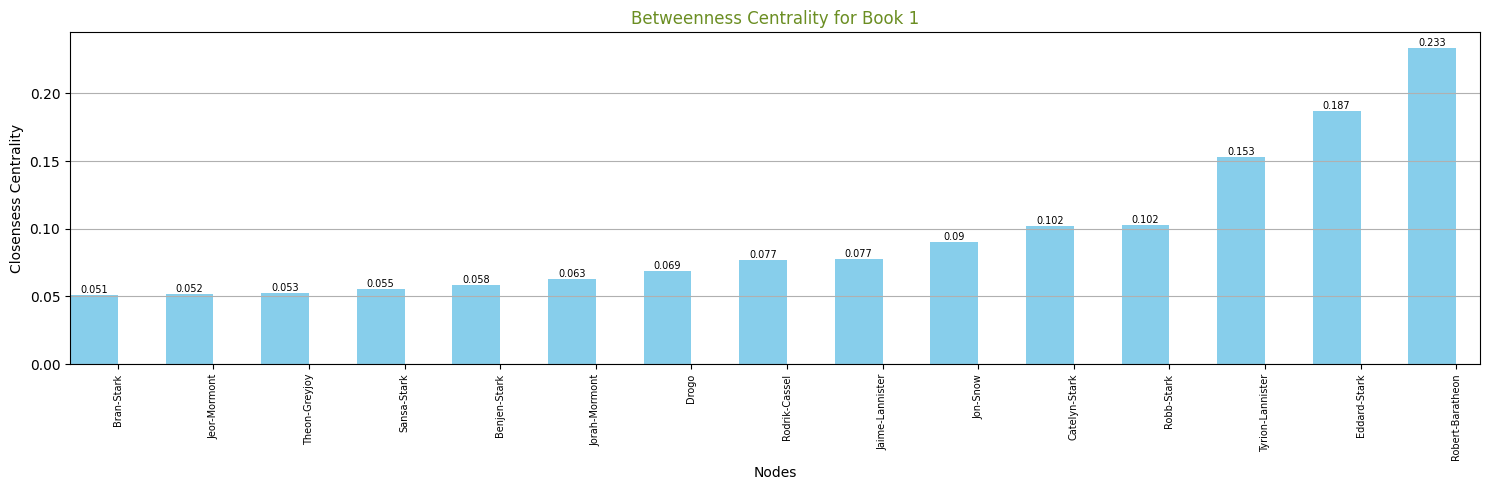

In [60]:
top_bet_nodes_1 = plot_betweenness_centrality(bet_1, 'Betweenness Centrality for Book 1', font_size=7, top_n=15)

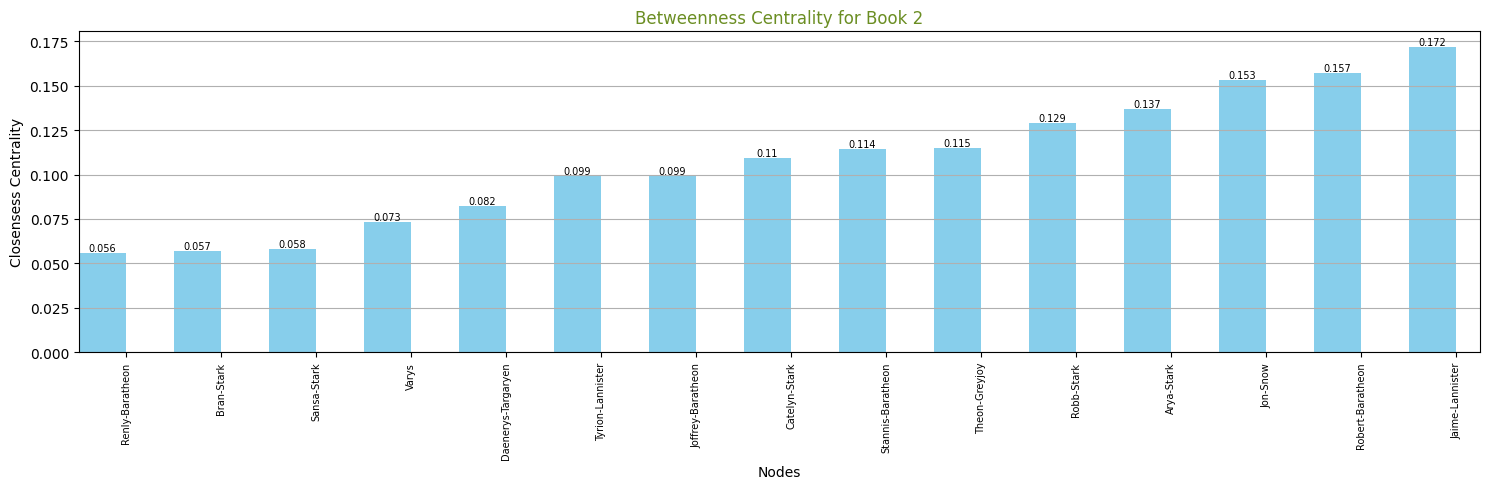

In [61]:
top_bet_nodes_2 = plot_betweenness_centrality(bet_2, 'Betweenness Centrality for Book 2', font_size=7, top_n=15)

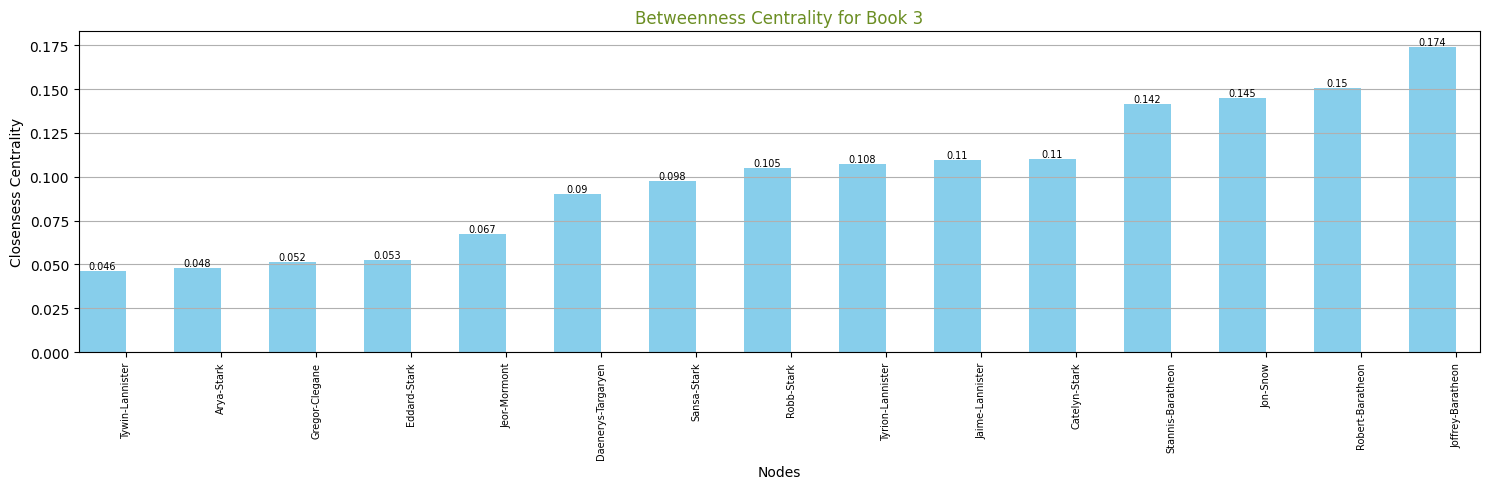

In [62]:
top_bet_nodes_3 = plot_betweenness_centrality(bet_3, 'Betweenness Centrality for Book 3', font_size=7, top_n=15)

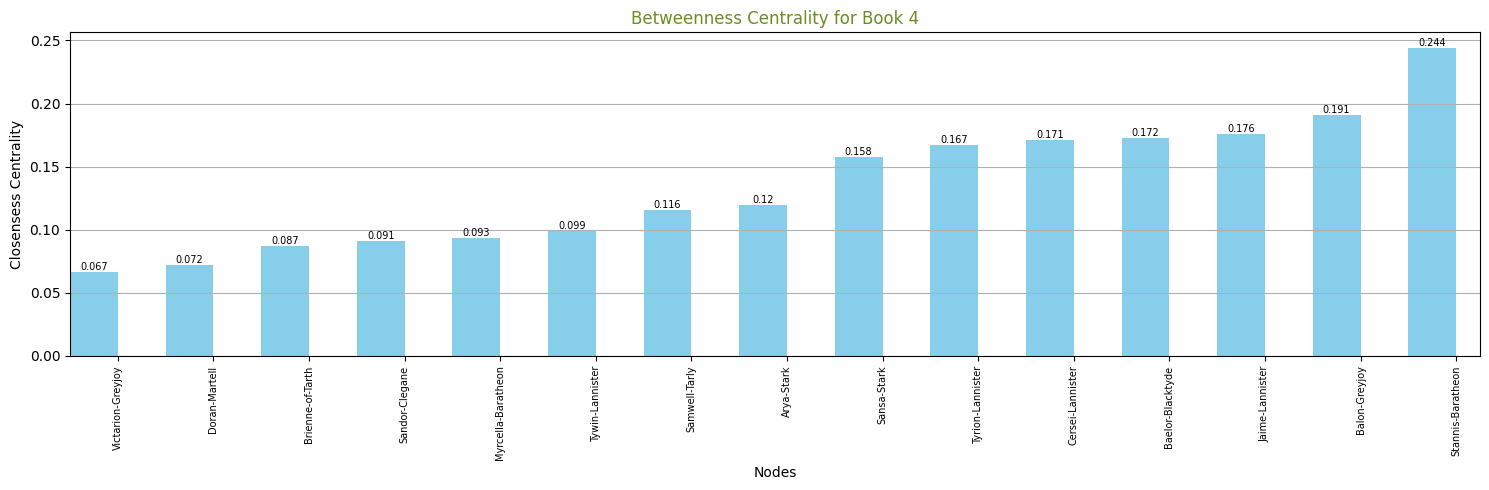

In [63]:
top_bet_nodes_4 = plot_betweenness_centrality(bet_4, 'Betweenness Centrality for Book 4', font_size=7, top_n=15)

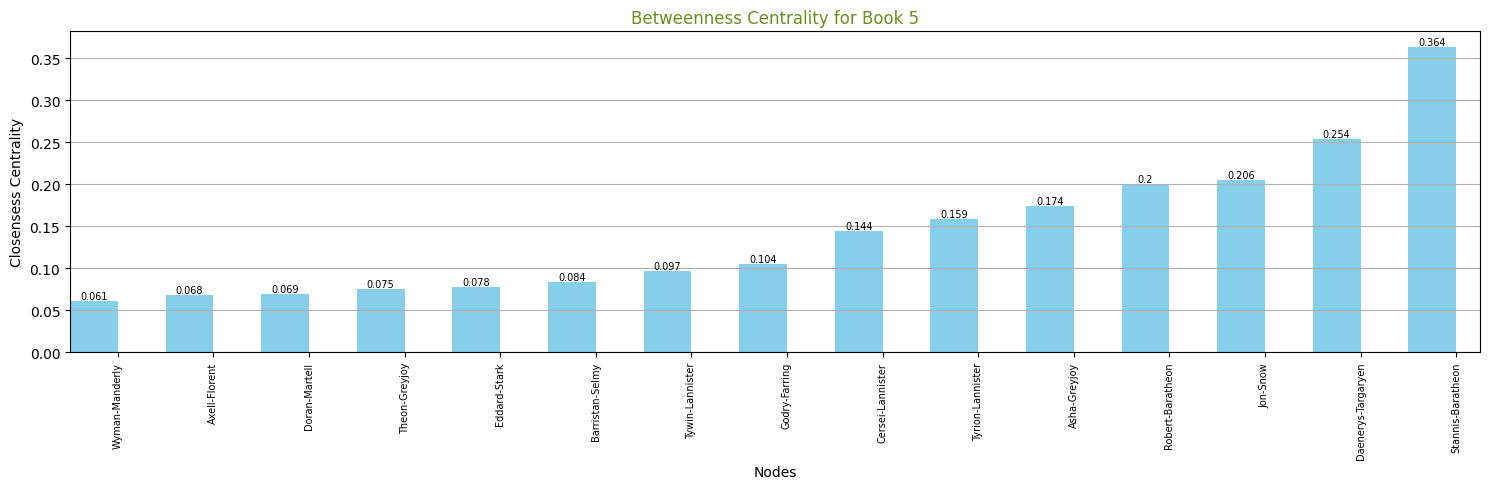

In [64]:
top_bet_nodes_5 = plot_betweenness_centrality(bet_5, 'Betweenness Centrality for Book 5', font_size=7, top_n=15)

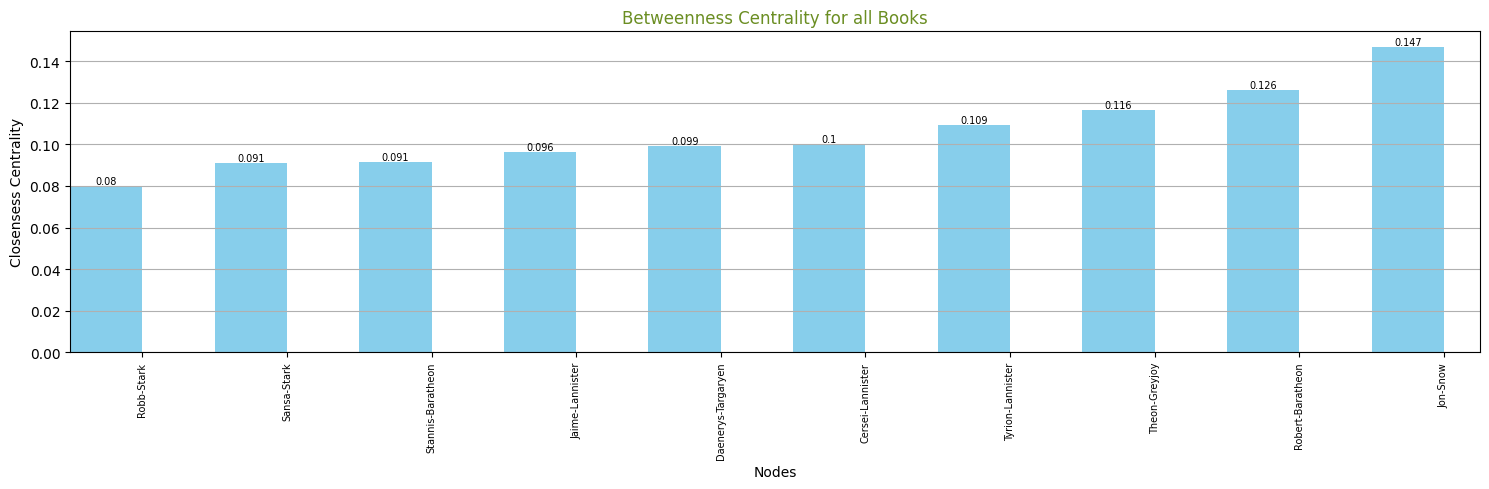

In [65]:
top_bet_nodes_all = plot_betweenness_centrality(bet_all, 'Betweenness Centrality for all Books', font_size=7, top_n=10)

In [66]:
top_common_nodes_BC = common_keys([top_bet_nodes_1, top_bet_nodes_2, top_bet_nodes_3, top_bet_nodes_4, top_bet_nodes_5])

In [67]:
top_common_nodes_BC

['Tyrion-Lannister']

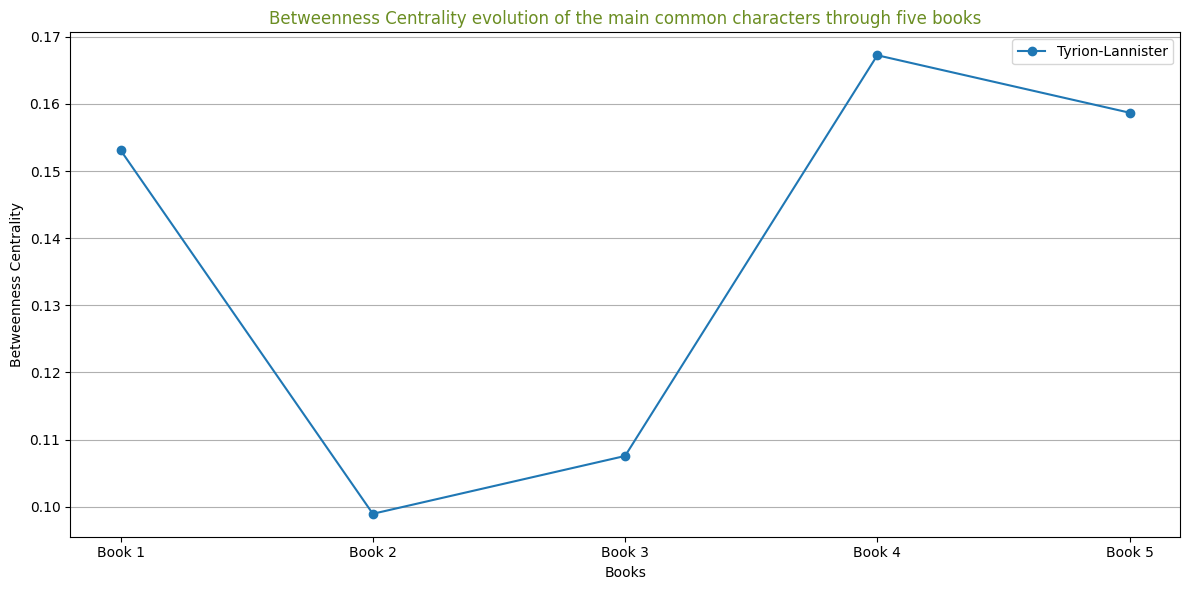

In [68]:
show_evolution([top_bet_nodes_1, top_bet_nodes_2, top_bet_nodes_3, top_bet_nodes_4, top_bet_nodes_5],
                        top_common_nodes_BC,
                        title="Betweenness Centrality evolution of the main common characters through five books",
                        xlabel="Books",
                        ylabel="Betweenness Centrality")

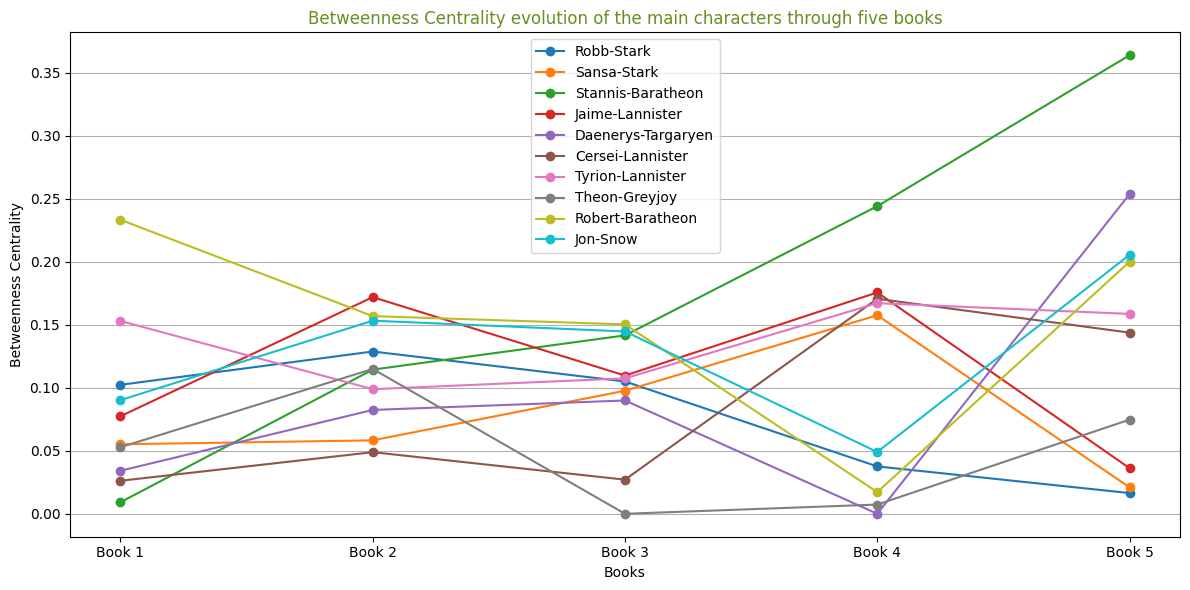

In [69]:
show_evolution([bet_1, bet_2, bet_3, bet_4, bet_5],
                        top_bet_nodes_all,
                        title="Betweenness Centrality evolution of the main characters through five books",
                        xlabel="Books",
                        ylabel="Betweenness Centrality")

### Clusters of Nodes

#### Cliques

In [116]:
def find_family_cliques(cliques, family_names):
    """
    Trova i cliques in cui i nomi della famiglia rappresentano la maggior parte dei membri.

    :param cliques: Lista di cliques, dove ogni clique è una lista di nomi.
    :param family_names: Lista di stringhe contenenti parte dei nomi dei personaggi.
    :return: Lista di cliques in cui i membri corrispondono alla maggior parte della famiglia.
    """
    family_cliques = []

    # Convertire la lista di nomi della famiglia in un set per un confronto più veloce
    family_set = set(family_names)

    for clique in cliques:
        # Contare quanti membri del clique corrispondono ai nomi della famiglia
        count = sum(1 for member in clique if any(name in member for name in family_set))

        # Verificare se la maggior parte dei membri del clique appartiene alla famiglia
        if count >= (3 * len(clique)) / 5:
            family_cliques.append(clique)

    return family_cliques

In [111]:
def find_largest_cliques(cliques, top_n=5):
    """
    Trova i 'top_n' cliques più grandi da una lista di cliques.

    :param cliques: Lista di cliques, dove ogni clique è una lista di membri.
    :param top_n: Numero di cliques più grandi da restituire.
    :return: Lista dei 'top_n' cliques più grandi.
    """
    # Ordinare i cliques in base alla loro dimensione (lunghezza)
    sorted_cliques = sorted(cliques, key=len, reverse=True)

    # Restituire i 'top_n' cliques più grandi
    return sorted_cliques[:top_n]

In [112]:
def find_common_cliques(cliques_list):
    """
    Trova i cliques comuni in una lista di liste di cliques.

    :param cliques_list: Lista di liste di cliques.
    :return: Lista di cliques comuni.
    """
    if not cliques_list:
        return []

    # Inizializzare il set dei cliques comuni con i cliques della prima lista
    common_cliques = set(map(tuple, cliques_list[0]))

    # Iterare attraverso le altre liste di cliques
    for cliques in cliques_list[1:]:
        common_cliques.intersection_update(set(map(tuple, cliques)))

    # Convertire i risultati in una lista di liste
    return [list(clique) for clique in common_cliques]

In [71]:
cliques_1 = list(nx.find_cliques(G_1))
cliques_2 = list(nx.find_cliques(G_2))
cliques_3 = list(nx.find_cliques(G_3))
cliques_4 = list(nx.find_cliques(G_4))
cliques_5 = list(nx.find_cliques(G_5))
cliques_all = list(nx.find_cliques(G_all))

In [115]:
# Stampo i cliques più grandi, sembrano identificare i gruppi di personaggi che nella storia interagiscono tra loro
for clique in cliques_1:
  if len(clique) > 9:
      print(clique)

['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish', 'Renly-Baratheon', 'Pycelle', 'Barristan-Selmy', 'Varys']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish', 'Renly-Baratheon', 'Jaime-Lannister', 'Barristan-Selmy', 'Sandor-Clegane']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish', 'Renly-Baratheon', 'Jaime-Lannister', 'Barristan-Selmy', 'Varys']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish', 'Renly-Baratheon', 'Jaime-Lannister', 'Tyrion-Lannister', 'Sandor-Clegane']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish', 'Renly-Baratheon', 'Jaime-Lannister', 'Tyrion-Lannister', 'Varys']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Petyr-Baelish'

In [117]:
# Molti cliques nel libro uno contengono gli Stark perchè buona parte della storia gira intorno a loro. Quindi stampo i cliques che rappresentano la loro famiglia
Stark_family_clique = find_family_cliques(cliques_1, family_names=["Stark"])
for clique in Stark_family_clique:
  if len(clique) > 4:
      print(clique)

['Eddard-Stark', 'Edmure-Tully', 'Jaime-Lannister', 'Catelyn-Stark', 'Robb-Stark']
['Eddard-Stark', 'Rodrik-Cassel', 'Bran-Stark', 'Jon-Snow', 'Robb-Stark', 'Joffrey-Baratheon', 'Catelyn-Stark', 'Arya-Stark']
['Eddard-Stark', 'Rickon-Stark', 'Bran-Stark', 'Robb-Stark', 'Jon-Snow', 'Catelyn-Stark', 'Tyrion-Lannister', 'Sansa-Stark']
['Eddard-Stark', 'Rickon-Stark', 'Bran-Stark', 'Robb-Stark', 'Jon-Snow', 'Catelyn-Stark', 'Tyrion-Lannister', 'Luwin']
['Eddard-Stark', 'Rickon-Stark', 'Bran-Stark', 'Robb-Stark', 'Jon-Snow', 'Catelyn-Stark', 'Arya-Stark', 'Sansa-Stark']
['Eddard-Stark', 'Luwin', 'Bran-Stark', 'Rickard-Karstark', 'Catelyn-Stark', 'Robb-Stark']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Jory-Cassel', 'Robb-Stark', 'Bran-Stark', 'Arya-Stark', 'Jon-Snow']
['Eddard-Stark', 'Robert-Baratheon', 'Sansa-Stark', 'Joffrey-Baratheon', 'Robb-Stark', 'Bran-Stark', 'Jon-Snow', 'Catelyn-Stark', 'Arya-Stark']
['Eddard-Stark', 'Rickard-Karstark', 'Jaime-Lannister', 'Catelyn-Stark',

In [118]:
Targaryen_family_clique = find_family_cliques(cliques_1, family_names=["Targaryen", "Mormont"])
for clique in Targaryen_family_clique:
  if len(clique) > 2:
      print(clique)

['Eddard-Stark', 'Aegon-I-Targaryen', 'Daenerys-Targaryen']
['Viserys-Targaryen', 'Daenerys-Targaryen', 'Jorah-Mormont', 'Rhaegar-Targaryen', 'Robert-Baratheon']


In [121]:
# Nel libro due molti cliques contengono i cognomi Lannister e Baratheon, proprio perché buona parte della storia è incentrata su di loro
LannisterBaratheon_family_clique = find_family_cliques(cliques_2, family_names=["Lannister", "Baratheon"])
for clique in LannisterBaratheon_family_clique:
  if len(clique) > 6:
      print(clique)

['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Tywin-Lannister', 'Jaime-Lannister', 'Robert-Baratheon', 'Robb-Stark', 'Arya-Stark']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Tywin-Lannister', 'Jaime-Lannister', 'Robert-Baratheon', 'Robb-Stark', 'Catelyn-Stark', 'Renly-Baratheon', 'Stannis-Baratheon']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Varys', 'Petyr-Baelish', 'Stannis-Baratheon', 'Eddard-Stark', 'Renly-Baratheon']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Varys', 'Robert-Baratheon', 'Stannis-Baratheon', 'Eddard-Stark', 'Renly-Baratheon', 'Robb-Stark']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Varys', 'Robert-Baratheon', 'Stannis-Baratheon', 'Pycelle']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Tommen-Baratheon', 'Sandor-Clegane', 'Myrcella-Baratheon']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Jaime-Lannister', 

In [122]:
Baratheon_family_clique = find_family_cliques(cliques_2, family_names=["Baratheon"])
for clique in Baratheon_family_clique:
  if len(clique) > 1:
      print(clique)

['Cressen', 'Stannis-Baratheon', 'Robert-Baratheon', 'Renly-Baratheon']
['Mace-Tyrell', 'Joffrey-Baratheon', 'Renly-Baratheon', 'Stannis-Baratheon', 'Loras-Tyrell']
['Steffon-Baratheon', 'Renly-Baratheon', 'Stannis-Baratheon']


In [123]:
# Stampo i cliques più grandi, sembrano identificare i gruppi di presonaggi che nella storia interagiscono tra loro
for clique in cliques_2:
  if len(clique) > 8:
      print(clique)

['Gregor-Clegane', 'Amory-Lorch', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Rafford', 'Dunsen', 'Chiswyck', 'Polliver', 'Tickler', 'Sandor-Clegane', 'Ilyn-Payne', 'Meryn-Trant']
['Gregor-Clegane', 'Amory-Lorch', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Rafford', 'Dunsen', 'Chiswyck', 'Polliver', 'Arya-Stark']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Tywin-Lannister', 'Jaime-Lannister', 'Robert-Baratheon', 'Robb-Stark', 'Catelyn-Stark', 'Renly-Baratheon', 'Stannis-Baratheon']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Varys', 'Robert-Baratheon', 'Stannis-Baratheon', 'Eddard-Stark', 'Renly-Baratheon', 'Robb-Stark']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Jaime-Lannister', 'Robert-Baratheon', 'Robb-Stark', 'Catelyn-Stark', 'Renly-Baratheon', 'Stannis-Baratheon']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Eddard-Stark', 'Robert-Baratheon', 'Robb-Stark', 'Renly-Baratheon', 'Stannis-Baratheon

In [124]:
# Oberyn-Martell death
Oberyn_Martell_death_clique = find_family_cliques(cliques_3, family_names=["Martell", "Lannister"])
for clique in Oberyn_Martell_death_clique:
  if len(clique) > 5:
      print(clique)

['Tyrion-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Cersei-Lannister', 'Jaime-Lannister', 'Oberyn-Martell', 'Tywin-Lannister']
['Tyrion-Lannister', 'Joffrey-Baratheon', 'Gregor-Clegane', 'Jaime-Lannister', 'Cersei-Lannister', 'Oberyn-Martell', 'Tywin-Lannister']
['Tyrion-Lannister', 'Elia-Martell', 'Oberyn-Martell', 'Cersei-Lannister', 'Jaime-Lannister', 'Gregor-Clegane']


In [125]:
Frey_family_clique = find_family_cliques(cliques_3, family_names=["Frey"])
for clique in Frey_family_clique:
  if len(clique) > 1:
      print(clique)

['Merrett-Frey', 'Lothar-Frey']
['Ryman-Frey', 'Petyr-Frey']
['Ryman-Frey', 'Robb-Stark', 'Stevron-Frey']
['Ryman-Frey', 'Robb-Stark', 'Olyvar-Frey']
['Stevron-Frey', 'Aegon-Frey-(son-of-Stevron)', 'Robb-Stark']
['Walder-Frey', 'Petyr-Frey']


In [126]:
Tyrell_family_clique = find_family_cliques(cliques_3, family_names=["Tyrell"])
for clique in Tyrell_family_clique:
  if len(clique) > 1:
      print(clique)

['Elinor-Tyrell', 'Alla-Tyrell', 'Megga-Tyrell', 'Sansa-Stark']
['Tyrion-Lannister', 'Willas-Tyrell', 'Sansa-Stark', 'Garlan-Tyrell', 'Loras-Tyrell']
['Tyrion-Lannister', 'Willas-Tyrell', 'Sansa-Stark', 'Margaery-Tyrell', 'Loras-Tyrell']
['Alerie-Hightower', 'Mace-Tyrell', 'Margaery-Tyrell']


In [127]:
Greyjoy_family_clique = find_family_cliques(cliques_4, family_names=["Greyjoy"])
for clique in Greyjoy_family_clique:
  if len(clique) > 3:
      print(clique)

['Asha-Greyjoy', 'Euron-Greyjoy', 'Victarion-Greyjoy', 'Balon-Greyjoy', 'Aeron-Greyjoy']
['Asha-Greyjoy', 'Euron-Greyjoy', 'Victarion-Greyjoy', 'Rodrik-Harlaw']
['Euron-Greyjoy', 'Victarion-Greyjoy', 'Baelor-Blacktyde', 'Balon-Greyjoy', 'Aeron-Greyjoy']


In [128]:
common_cliques = find_common_cliques([cliques_1, cliques_2, cliques_3, cliques_4, cliques_5])
if common_cliques:
    print("Common found Cliques:")
    for clique in common_cliques:
        print(clique)
else:
    print("None Common Clique found.")

None Common Clique found.


In [129]:
top_cliques_all = find_largest_cliques(cliques_all, top_n=15)

In [130]:
print("The greatest cliques among all books are:")
for clique in top_cliques_all:
  print(clique)

The greatest cliques among all books are:
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Jaime-Lannister', 'Robert-Baratheon', 'Eddard-Stark', 'Petyr-Baelish', 'Renly-Baratheon', 'Varys', 'Stannis-Baratheon', 'Tywin-Lannister', 'Robb-Stark', 'Catelyn-Stark']
['Amory-Lorch', 'Arya-Stark', 'Joffrey-Baratheon', 'Cersei-Lannister', 'Gregor-Clegane', 'Meryn-Trant', 'Sandor-Clegane', 'Rafford', 'Ilyn-Payne', 'Tickler', 'Chiswyck', 'Dunsen', 'Polliver']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Jaime-Lannister', 'Robert-Baratheon', 'Eddard-Stark', 'Petyr-Baelish', 'Renly-Baratheon', 'Varys', 'Stannis-Baratheon', 'Tywin-Lannister', 'Pycelle']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'Sansa-Stark', 'Jaime-Lannister', 'Robert-Baratheon', 'Brienne-of-Tarth', 'Renly-Baratheon', 'Stannis-Baratheon', 'Catelyn-Stark', 'Tywin-Lannister', 'Robb-Stark']
['Tyrion-Lannister', 'Cersei-Lannister', 'Joffrey-Baratheon', 'S

#### Cores

I K-Cores sono una misura di centralità, servono spesso per vedere quali strutture sono centrali nel grafo e quali sono periferiche. Quindi ha senso cercare i core più grandi in un grafo.

Ha anche senso vedere se ci sono dei personaggi presenti nei 5 libri nei core più grandi.
In teoria, se un libro si concentra su un certo gruppo di personaggi allora il core con k grande dovrebbe avere dentro quei personaggi.

In [150]:
def plot_k_core(k_core, title, font_size=10):

      plt.figure(figsize=(12, 6))

      pos = nx.spring_layout(k_core)
      nx.draw(k_core, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=font_size, font_color='red')

      # Mostrare il grafo
      plt.title(title, fontsize=18, color="blue")
      plt.show()


      return list(k_core.nodes)

In [192]:
k_core_1 = nx.k_core(G_1, k=11, core_number=None)
k_core_2 = nx.k_core(G_2, k=11, core_number=None)
k_core_3 = nx.k_core(G_3, k=7, core_number=None)
k_core_4 = nx.k_core(G_4, k=6, core_number=None)
k_core_5 = nx.k_core(G_5, k=4, core_number=None)
k_core_all = nx.k_core(G_all, k=8, core_number=None)

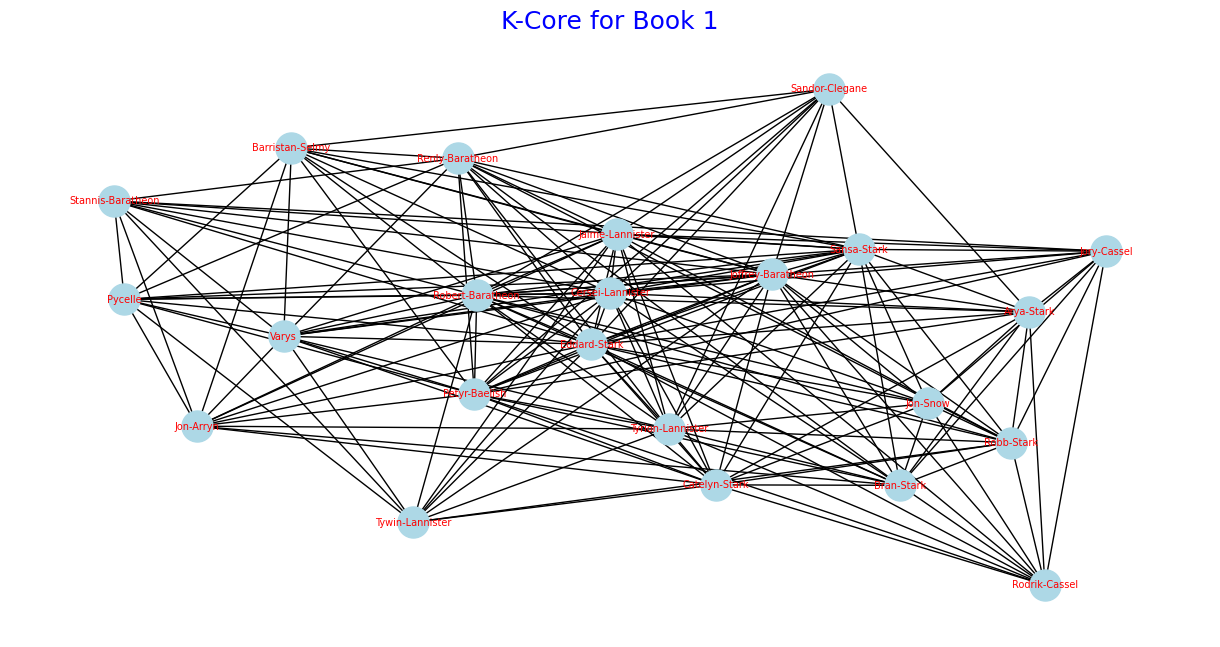

In [151]:
k_core_1_nodes = plot_k_core(k_core_1, 'K-Core for Book 1', font_size=7)

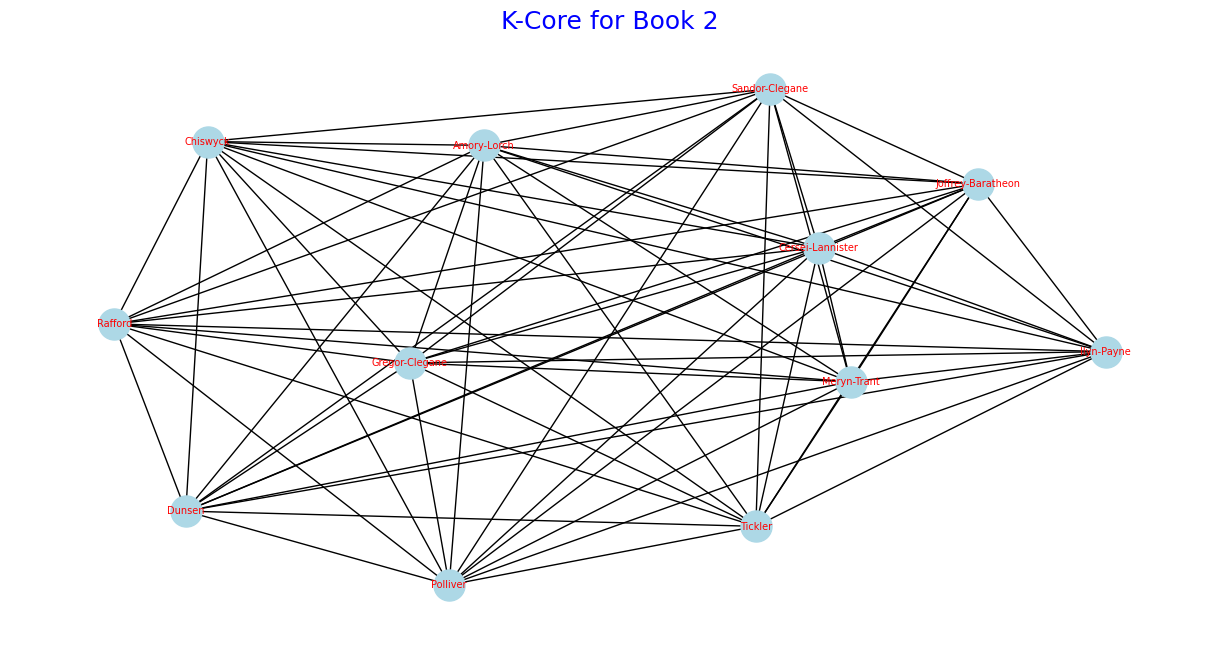

In [156]:
k_core_2_nodes = plot_k_core(k_core_2, 'K-Core for Book 2', font_size=7)

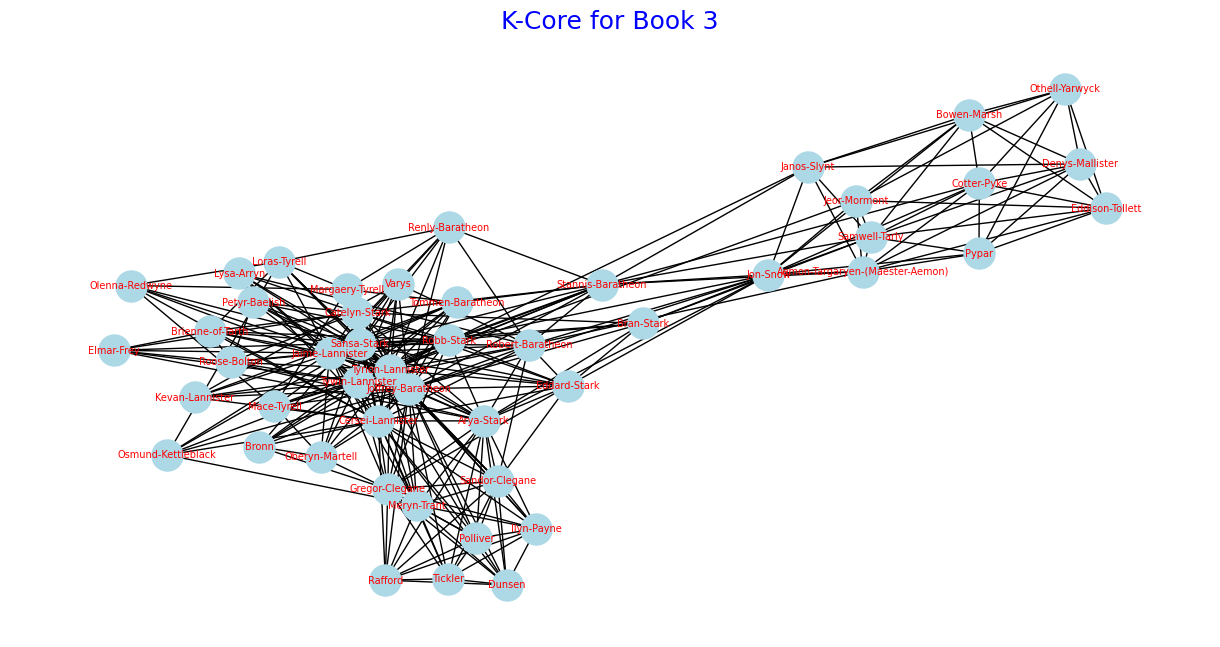

In [170]:
k_core_3_nodes = plot_k_core(k_core_3, 'K-Core for Book 3', font_size=7)

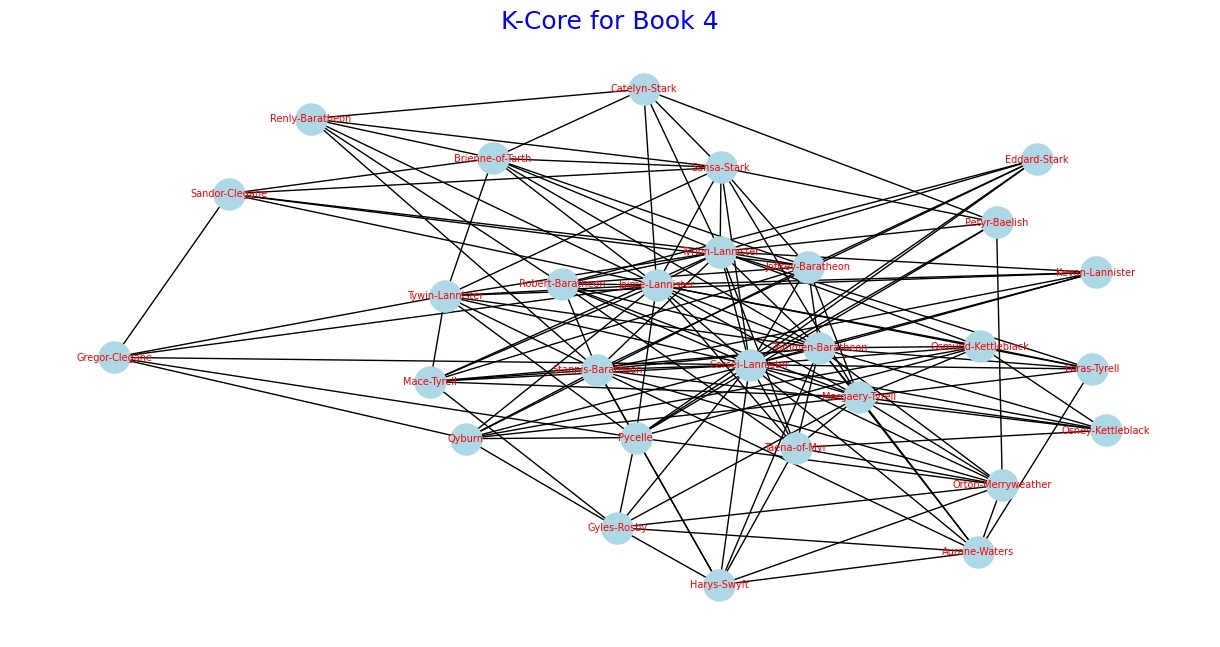

In [173]:
k_core_4_nodes = plot_k_core(k_core_4, 'K-Core for Book 4', font_size=7)

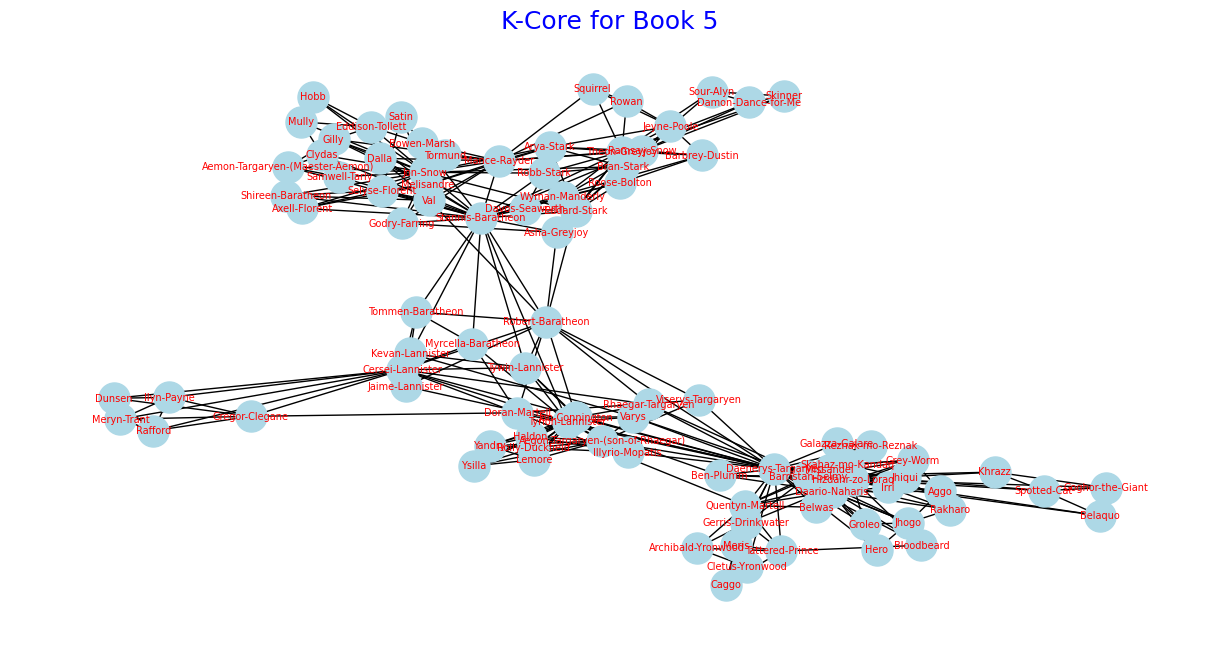

In [183]:
k_core_5_nodes = plot_k_core(k_core_5, 'K-Core for Book 5', font_size=7)

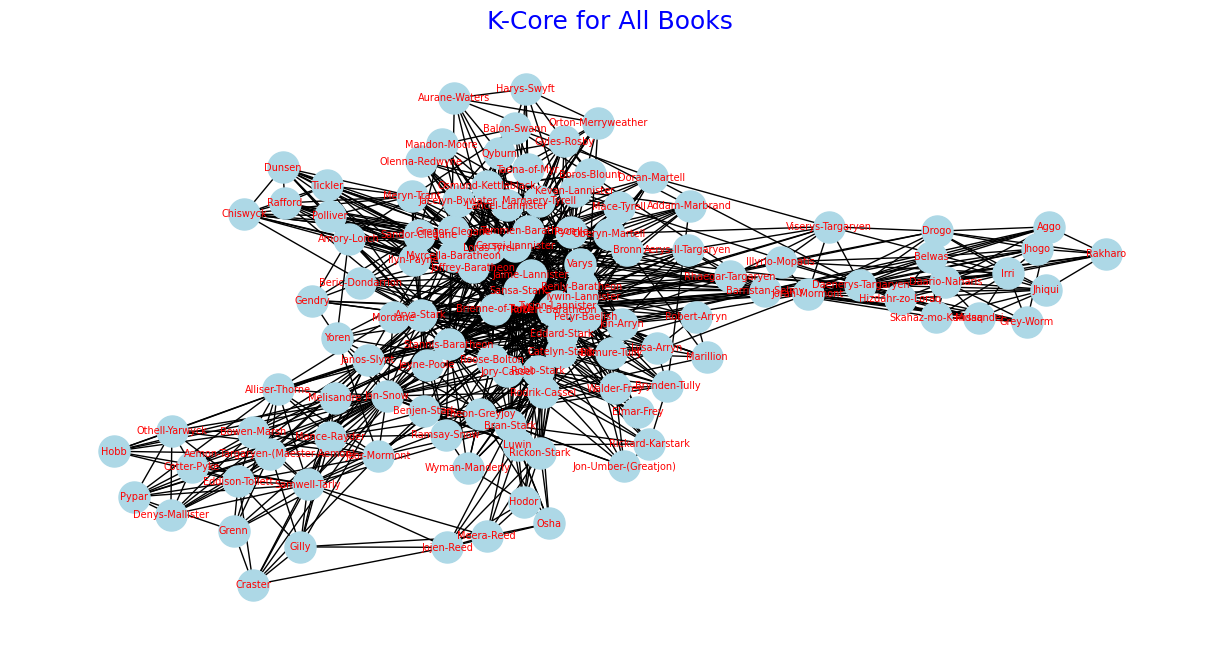

In [193]:
k_core_all_nodes = plot_k_core(k_core_all, 'K-Core for All Books', font_size=7)

#### K-Components

#### Local Clustering

### Similarity-Equivalence

#### Structural Equivalence

#### Regular Equivalence

### Homophily-Assortative Mixing

## Network

### Degree Distribution

### Eigenvector Centrality

### Closeness Centrality

### Betweeness Centrality

### Local Clustering Coefficient

### Cohesion

#### Density

#### Connectedness

#### Compactness

### Reciprocity

### Transitivity

### Centralisation and Core-periphery Indices

# Conclusions and Results